In [1]:
#dataset.py

import os
import json
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
import random

COLOR_LIST = ["red", "green", "blue", "yellow", "orange", "magenta", "cyan", "purple"]
COLOR_TO_IDX = {c: i for i, c in enumerate(COLOR_LIST)}

def color_name_to_onehot(color_name):
    idx = COLOR_TO_IDX[color_name]
    one_hot = torch.zeros(len(COLOR_LIST), dtype=torch.float32)
    one_hot[idx] = 1.0
    return one_hot

class PolygonColorDataset(Dataset):
    def __init__(self, input_dir, output_dir, json_path, augment=False):
        with open(json_path, 'r') as f:
            self.data = json.load(f)

        self.input_dir = input_dir
        self.output_dir = output_dir
        self.augment = augment
        self.resize = transforms.Resize((144, 144))  # Upscale first
        self.to_tensor = transforms.ToTensor()
        self.center_crop = transforms.CenterCrop(128)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_img = Image.open(os.path.join(self.input_dir, item["input_polygon"])).convert("RGB")
        output_img = Image.open(os.path.join(self.output_dir, item["output_image"])).convert("RGB")

        input_img = self.resize(input_img)
        output_img = self.resize(output_img)

        if self.augment:
            angle = random.uniform(-30, 30)
            input_img = TF.rotate(input_img, angle)
            output_img = TF.rotate(output_img, angle)

            if random.random() > 0.5:
                input_img = TF.hflip(input_img)
                output_img = TF.hflip(output_img)

            if random.random() > 0.5:
                input_img = TF.vflip(input_img)
                output_img = TF.vflip(output_img)

        input_img = self.center_crop(input_img)
        output_img = self.center_crop(output_img)

        input_tensor = self.to_tensor(input_img)
        output_tensor = self.to_tensor(output_img)

        color_onehot = color_name_to_onehot(item["colour"])

        return input_tensor, color_onehot, output_tensor


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FiLMLayer(nn.Module):
    """Feature-wise Linear Modulation layer"""
    def __init__(self, feature_channels, condition_dim):
        super().__init__()
        self.feature_channels = feature_channels

        # Generate gamma (scale) and beta (shift) parameters from condition
        self.film_generator = nn.Sequential(
            nn.Linear(condition_dim, feature_channels * 2),
            nn.ReLU(),
            nn.Linear(feature_channels * 2, feature_channels * 2)
        )

    def forward(self, features, condition):
        # Generate FiLM parameters
        film_params = self.film_generator(condition)  # (B, feature_channels * 2)

        # Split into gamma and beta
        gamma, beta = torch.chunk(film_params, 2, dim=1)  # Each: (B, feature_channels)

        # Reshape for broadcasting: (B, C, 1, 1)
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)
        beta = beta.unsqueeze(-1).unsqueeze(-1)

        # Apply FiLM: gamma * features + beta
        return gamma * features + beta

class DoubleConvFiLM(nn.Module):
    """DoubleConv block with FiLM conditioning"""
    def __init__(self, in_c, out_c, condition_dim=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.film1 = FiLMLayer(out_c, condition_dim)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.film2 = FiLMLayer(out_c, condition_dim)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, condition):
        # First conv + BN + FiLM + ReLU
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.film1(x, condition)
        x = self.relu1(x)

        # Second conv + BN + FiLM + ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.film2(x, condition)
        x = self.relu2(x)

        return x

class DoubleConv(nn.Module):
    """Original DoubleConv block (for encoder)"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

"""class UNetFiLM(nn.Module):
    def __init__(self, in_channels=3, cond_dim=8):
        super().__init__()
        self.cond_dim = cond_dim

        # Original spatial conditioning (kept for compatibility)
        self.cond_embed = nn.Sequential(
            nn.Linear(cond_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 128 * 128)
        )

        # New: Color embedding for FiLM conditioning
        self.color_embed = nn.Sequential(
            nn.Linear(cond_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )

        # Encoder (keep original structure for boundary detection)
        self.down1 = DoubleConv(6, 64)       # image + color cond
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with FiLM
        self.bottleneck = DoubleConvFiLM(512, 1024, condition_dim=64)

        # Decoder with FiLM conditioning (where color filling happens)
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec3 = DoubleConvFiLM(1024, 512, condition_dim=64)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = DoubleConvFiLM(512, 256, condition_dim=64)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = DoubleConvFiLM(256, 128, condition_dim=64)

        self.up0 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec0 = DoubleConvFiLM(128, 64, condition_dim=64)

        self.out = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x_img, x_color):
        # Original spatial conditioning
        cond = self.cond_embed(x_color).view(-1, 3, 128, 128)
        x = torch.cat([x_img, cond], dim=1)  # (B, 6, 128, 128)

        # FiLM conditioning embedding
        color_embed = self.color_embed(x_color)  # (B, 64)

        # Encoder (unchanged - good for boundary detection)
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        # Bottleneck with FiLM
        bottleneck = self.bottleneck(self.pool4(d4), color_embed)

        # Decoder with FiLM conditioning
        u3 = self.up3(bottleneck)
        u3 = torch.cat([u3, d4], dim=1)
        u3 = self.dec3(u3, color_embed)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d3], dim=1)
        u2 = self.dec2(u2, color_embed)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d2], dim=1)
        u1 = self.dec1(u1, color_embed)

        u0 = self.up0(u1)
        u0 = torch.cat([u0, d1], dim=1)
        u0 = self.dec0(u0, color_embed)

        return self.out(u0)"""


class UNetFullFiLM(nn.Module):
    def __init__(self, in_channels=3, cond_dim=8):
        super().__init__()
        self.cond_dim = cond_dim


        self.color_embed = nn.Sequential(
            nn.Linear(cond_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )

        # Encoder with FiLM conditioning
        self.down1 = DoubleConvFiLM(in_channels, 64, condition_dim=64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConvFiLM(64, 128, condition_dim=64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConvFiLM(128, 256, condition_dim=64)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConvFiLM(256, 512, condition_dim=64)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConvFiLM(512, 1024, condition_dim=64)

        # Decoder
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec3 = DoubleConvFiLM(1024, 512, condition_dim=64)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = DoubleConvFiLM(512, 256, condition_dim=64)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = DoubleConvFiLM(256, 128, condition_dim=64)

        self.up0 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec0 = DoubleConvFiLM(128, 64, condition_dim=64)

        self.out = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x_img, x_color):
        # Only FiLM conditioning (no spatial concatenation)
        color_embed = self.color_embed(x_color)  # (B, 64)

        # Encoder with FiLM
        d1 = self.down1(x_img, color_embed)
        d2 = self.down2(self.pool1(d1), color_embed)
        d3 = self.down3(self.pool2(d2), color_embed)
        d4 = self.down4(self.pool3(d3), color_embed)

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(d4), color_embed)

        # Decoder
        u3 = self.up3(bottleneck)
        u3 = torch.cat([u3, d4], dim=1)
        u3 = self.dec3(u3, color_embed)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d3], dim=1)
        u2 = self.dec2(u2, color_embed)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d2], dim=1)
        u1 = self.dec1(u1, color_embed)

        u0 = self.up0(u1)
        u0 = torch.cat([u0, d1], dim=1)
        u0 = self.dec0(u0, color_embed)

        return self.out(u0)


In [4]:
#training.py
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import wandb
import os

# Define paths from Google Drive
DATASET_ROOT = "/content/drive/MyDrive/ayna_dataset"
MODEL_SAVE_PATH = "/content/drive/MyDrive/unet_film_onehot_aug.pth"

# Initialize wandb
wandb.init(project="ayna-unet-film-onehot-aug")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Improved loss function for color segmentation
class ColorSegmentationLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=2.0):
        super().__init__()
        self.alpha = alpha  # Weight for pixel-wise loss
        self.beta = beta    # Weight for color consistency loss
        self.mse = nn.MSELoss()
        self.ce = nn.CrossEntropyLoss()

    def rgb_to_class(self, rgb_tensor):
        """Convert RGB output to class predictions for color accuracy"""
        # This assumes you have a way to map RGB values back to color classes
        # Adjust based on your color encoding scheme
        return torch.argmax(rgb_tensor, dim=1)

    def forward(self, pred, target, color_condition):
        # Primary pixel-wise loss
        pixel_loss = self.mse(pred, target)

        # Color consistency loss - penalize color deviations within regions
        # Compute gradient-based edge mask to identify polygon boundaries
        pred_gray = torch.mean(pred, dim=1, keepdim=True)
        target_gray = torch.mean(target, dim=1, keepdim=True)

        # Simple gradient-based boundary detection
        pred_grad_x = torch.abs(pred_gray[:, :, :, 1:] - pred_gray[:, :, :, :-1])
        pred_grad_y = torch.abs(pred_gray[:, :, 1:, :] - pred_gray[:, :, :-1, :])

        # Mask non-boundary regions for color consistency
        interior_mask_x = (pred_grad_x < 0.1).float()
        interior_mask_y = (pred_grad_y < 0.1).float()

        # Color consistency within regions
        color_consistency_x = torch.mean(interior_mask_x * pred_grad_x)
        color_consistency_y = torch.mean(interior_mask_y * pred_grad_y)

        consistency_loss = color_consistency_x + color_consistency_y

        return self.alpha * pixel_loss + self.beta * consistency_loss

def calculate_color_accuracy(pred, target, threshold=0.1):
    """Calculate pixel-wise color accuracy"""
    color_diff = torch.norm(pred - target, dim=1)  # L2 distance in RGB space
    accurate_pixels = (color_diff < threshold).float()
    return torch.mean(accurate_pixels)

def calculate_region_color_accuracy(pred, target):
    """Calculate color accuracy within detected regions"""
    # Simple version - you can make this more sophisticated
    pred_flat = pred.view(-1, 3)
    target_flat = target.view(-1, 3)

    # Calculate per-pixel color similarity
    color_similarity = 1.0 - torch.norm(pred_flat - target_flat, dim=1) / (3.0 ** 0.5)
    return torch.mean(color_similarity)

# Load datasets
train_dataset = PolygonColorDataset(
    input_dir=os.path.join(DATASET_ROOT, "training/inputs"),
    output_dir=os.path.join(DATASET_ROOT, "training/outputs"),
    json_path=os.path.join(DATASET_ROOT, "training/data.json"),
    augment=True
)
val_dataset = PolygonColorDataset(
    input_dir=os.path.join(DATASET_ROOT, "validation/inputs"),
    output_dir=os.path.join(DATASET_ROOT, "validation/outputs"),
    json_path=os.path.join(DATASET_ROOT, "validation/data.json"),
    augment=False
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Initialize model with FiLM
model = UNetFullFiLM(in_channels=3, cond_dim=8).to(device)  # Specify your cond_dim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Use improved loss function
criterion = ColorSegmentationLoss(alpha=1.0, beta=2.0)

# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

# Training loop
best_val_loss = float('inf')

for epoch in range(1, 76):
    model.train()
    total_loss = 0
    total_color_acc = 0
    total_region_acc = 0

    for x_img, x_color, y in train_loader:
        x_img, x_color, y = x_img.to(device), x_color.to(device), y.to(device)

        out = model(x_img, x_color)
        loss = criterion(out, y, x_color)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate color-specific metrics
        with torch.no_grad():
            color_acc = calculate_color_accuracy(out, y)
            region_acc = calculate_region_color_accuracy(out, y)
            total_color_acc += color_acc.item()
            total_region_acc += region_acc.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_color_acc = total_color_acc / len(train_loader)
    avg_region_acc = total_region_acc / len(train_loader)

    wandb.log({
        "train_loss": avg_train_loss,
        "train_color_accuracy": avg_color_acc,
        "train_region_accuracy": avg_region_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    # Validation
    model.eval()
    val_loss = 0
    val_color_acc = 0
    val_region_acc = 0

    with torch.no_grad():
        for x_img, x_color, y in val_loader:
            x_img, x_color, y = x_img.to(device), x_color.to(device), y.to(device)
            out = model(x_img, x_color)
            val_loss += criterion(out, y, x_color).item()

            # Validation metrics
            color_acc = calculate_color_accuracy(out, y)
            region_acc = calculate_region_color_accuracy(out, y)
            val_color_acc += color_acc.item()
            val_region_acc += region_acc.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_color_acc = val_color_acc / len(val_loader)
    avg_val_region_acc = val_region_acc / len(val_loader)

    wandb.log({
        "val_loss": avg_val_loss,
        "val_color_accuracy": avg_val_color_acc,
        "val_region_accuracy": avg_val_region_acc
    })

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, MODEL_SAVE_PATH)
        print(f"✓ New best model saved at epoch {epoch}")

    print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Color Acc: {avg_val_color_acc:.3f} | Region Acc: {avg_val_region_acc:.3f}")

# Save final model
final_path = MODEL_SAVE_PATH.replace('.pth', '_final.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_val_loss': avg_val_loss,
}, final_path)

print(f"Training completed!")
print(f"Best model saved to: {MODEL_SAVE_PATH}")
print(f"Final model saved to: {final_path}")



Model initialized with 45798787 parameters
✓ New best model saved at epoch 1
Epoch 001 | Train Loss: 0.7885 | Val Loss: 0.8241 | Color Acc: 0.000 | Region Acc: 0.127
✓ New best model saved at epoch 2
Epoch 002 | Train Loss: 0.7493 | Val Loss: 0.8120 | Color Acc: 0.000 | Region Acc: 0.133
✓ New best model saved at epoch 3
Epoch 003 | Train Loss: 0.7388 | Val Loss: 0.7998 | Color Acc: 0.000 | Region Acc: 0.139
✓ New best model saved at epoch 4
Epoch 004 | Train Loss: 0.7197 | Val Loss: 0.7878 | Color Acc: 0.000 | Region Acc: 0.145
✓ New best model saved at epoch 5
Epoch 005 | Train Loss: 0.7071 | Val Loss: 0.7759 | Color Acc: 0.000 | Region Acc: 0.151
✓ New best model saved at epoch 6
Epoch 006 | Train Loss: 0.6895 | Val Loss: 0.7635 | Color Acc: 0.000 | Region Acc: 0.157
✓ New best model saved at epoch 7
Epoch 007 | Train Loss: 0.6848 | Val Loss: 0.7511 | Color Acc: 0.000 | Region Acc: 0.163
✓ New best model saved at epoch 8
Epoch 008 | Train Loss: 0.6577 | Val Loss: 0.7383 | Color Acc:

✅ Loaded FiLM model from epoch 72
📊 Best validation loss: 0.0074


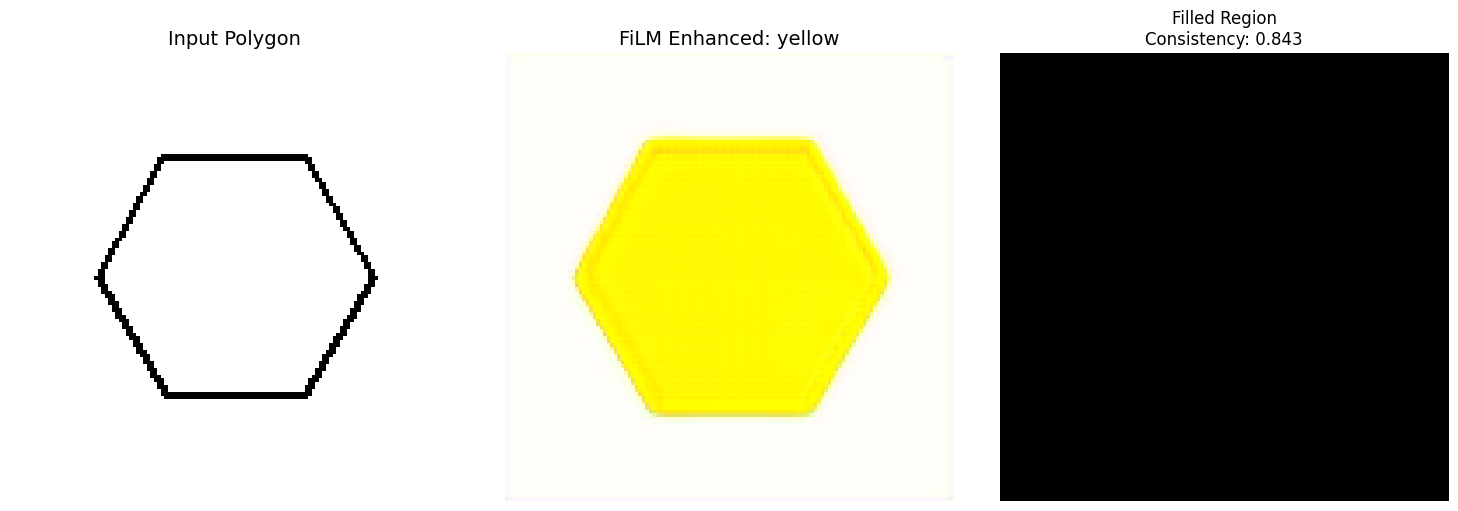

In [8]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

transform = T.Compose([T.Resize((144, 144)), T.CenterCrop(128), T.ToTensor()])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_film(image_path, color_name, model_path, cond_dim=8):
    """Test your FiLM-enhanced UNet"""
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    color_vector = color_name_to_onehot(color_name).unsqueeze(0).to(device)

    # Initialize FiLM model with correct parameters
    model = UNetFullFiLM(in_channels=3, cond_dim=cond_dim).to(device)

    # Load the FiLM model checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded FiLM model from epoch {checkpoint.get('epoch', 'unknown')}")
        print(f"Best validation loss: {checkpoint.get('best_val_loss', 'unknown'):.4f}")
    else:
        model.load_state_dict(checkpoint)

    model.eval()

    # Inference
    with torch.no_grad():
        pred = model(img_tensor, color_vector)
        pred_np = pred.squeeze().permute(1, 2, 0).cpu().numpy()
        pred_np = np.clip(pred_np, 0, 1)

    # Enhanced visualization
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Polygon", fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_np)
    plt.title(f"FiLM Enhanced: {color_name}", fontsize=14)
    plt.axis('off')

    # Color consistency analysis
    plt.subplot(1, 3, 3)
    # Create a mask to analyze color consistency within the filled region
    gray_pred = np.mean(pred_np, axis=2)
    filled_mask = gray_pred > 0.1  # Areas that have been filled

    if np.any(filled_mask):
        color_variance = np.std(pred_np[filled_mask], axis=0)
        consistency_score = 1.0 - np.mean(color_variance)
        plt.imshow(filled_mask, cmap='gray')
        plt.title(f"Filled Region\nConsistency: {consistency_score:.3f}", fontsize=12)
    else:
        plt.imshow(pred_np)
        plt.title("Analysis View", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return pred_np

# Test your FiLM model
result = predict_film(
    image_path="/content/drive/MyDrive/ayna_dataset/training/inputs/hexagon.png",
    color_name="yellow",
    model_path="/content/drive/MyDrive/unet_film_onehot_aug.pth"  # This should now be your FiLM model
)


✅ Loaded FiLM model from epoch 72
📊 Best validation loss: 0.0074

🎨 FiLM Model Testing: Circle


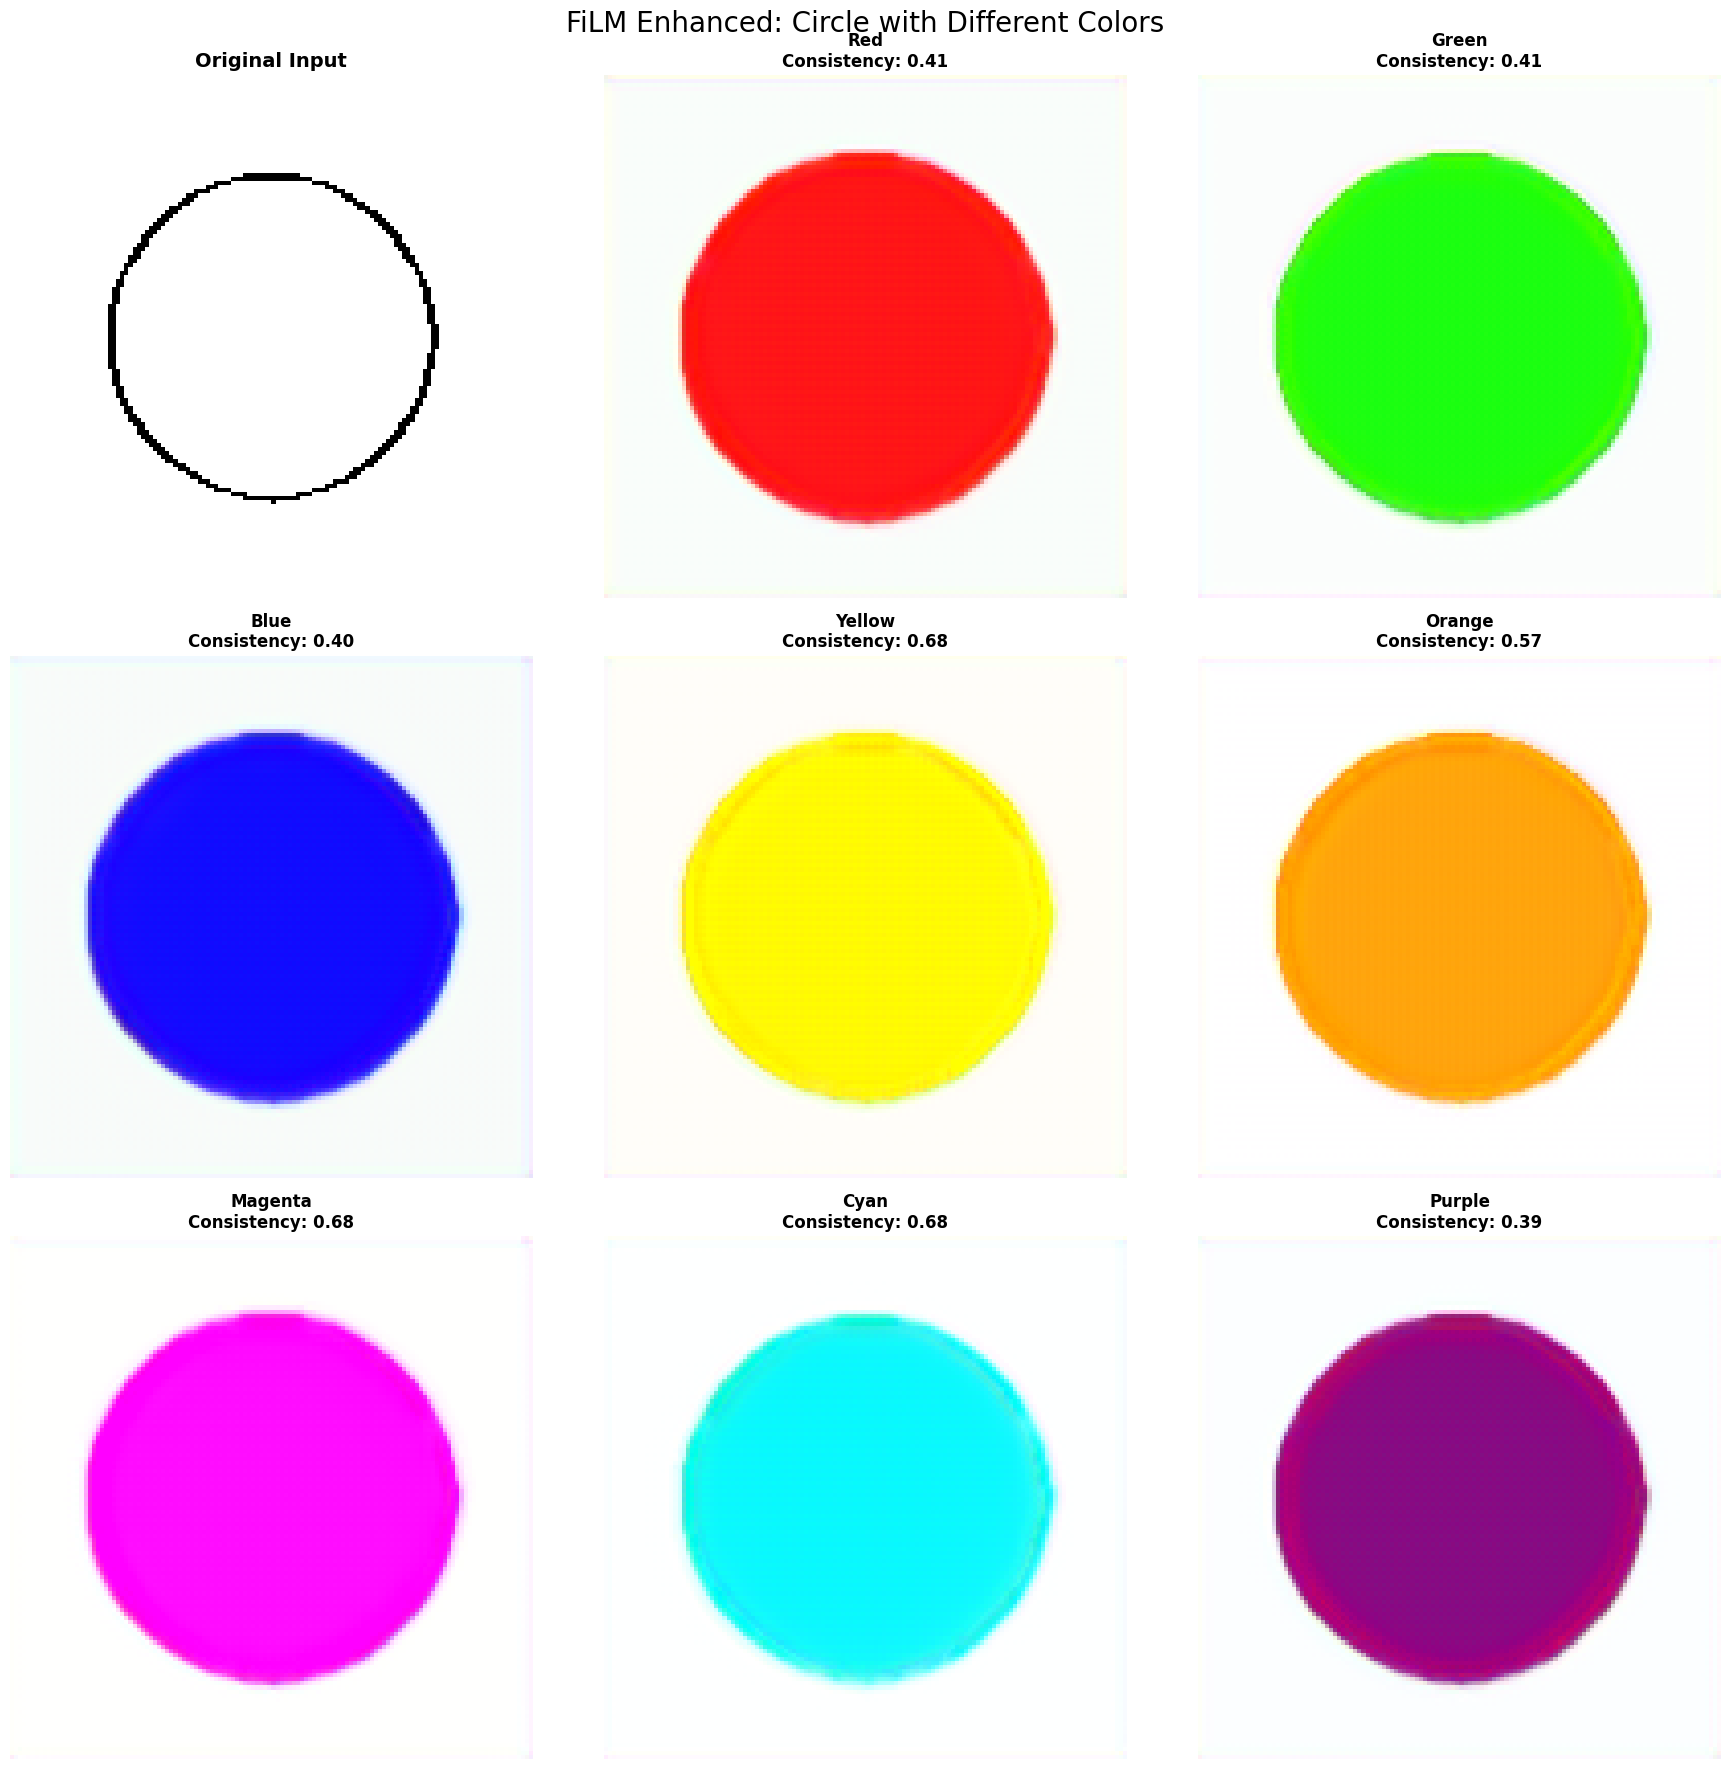


🎨 FiLM Model Testing: Square


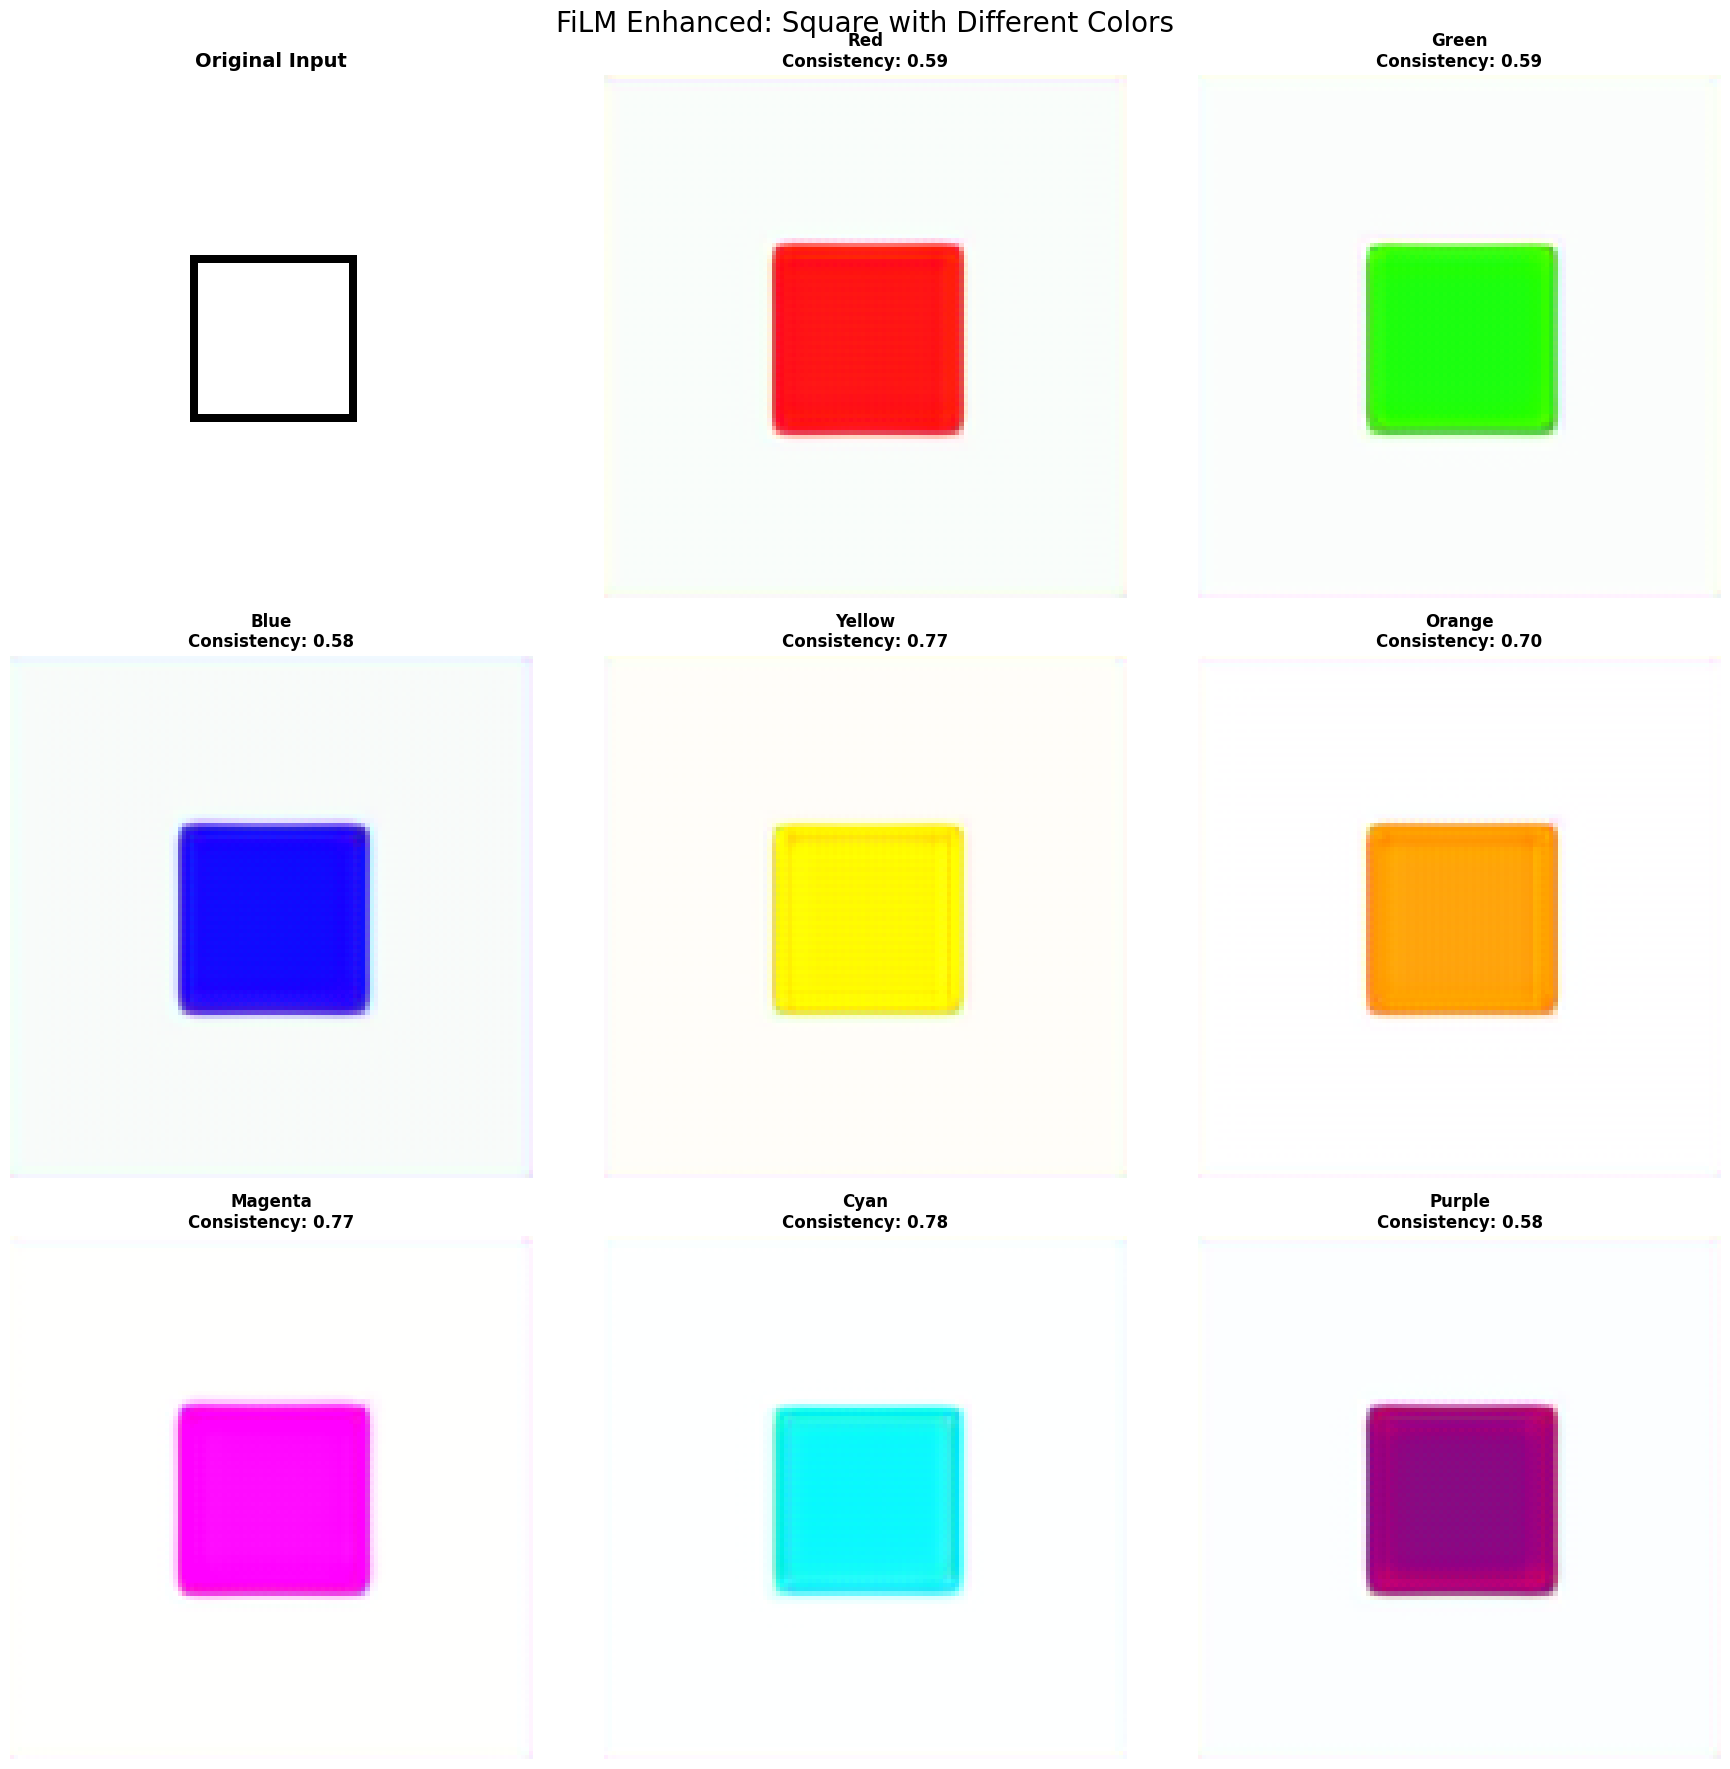


🎨 FiLM Model Testing: Triangle


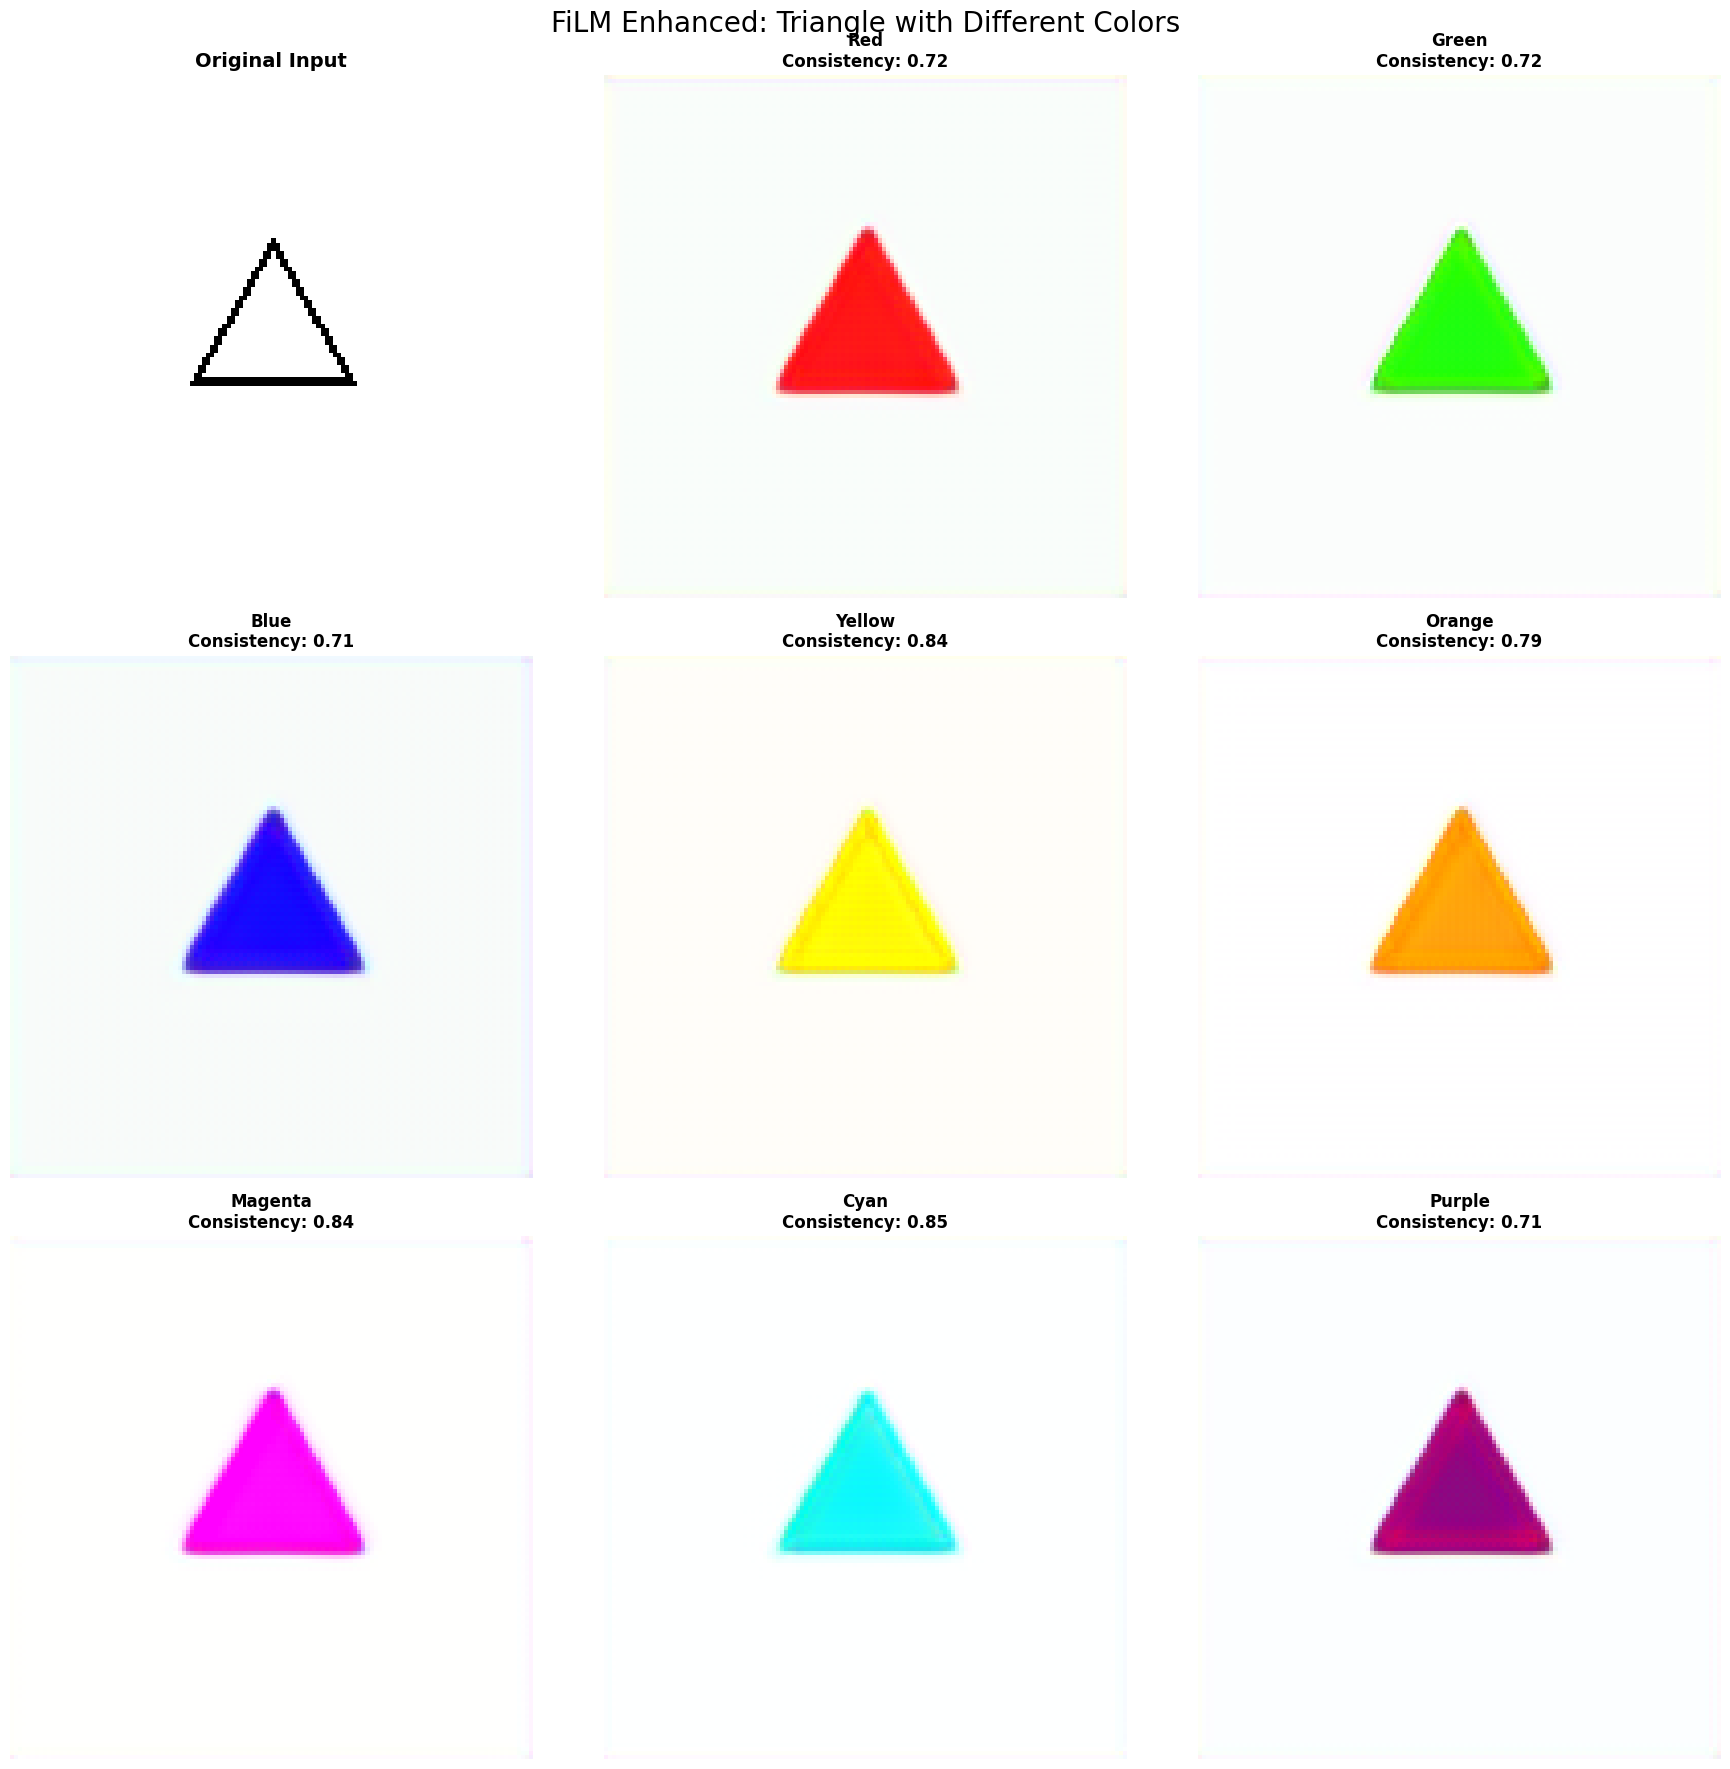


🎨 FiLM Model Testing: Hexagon


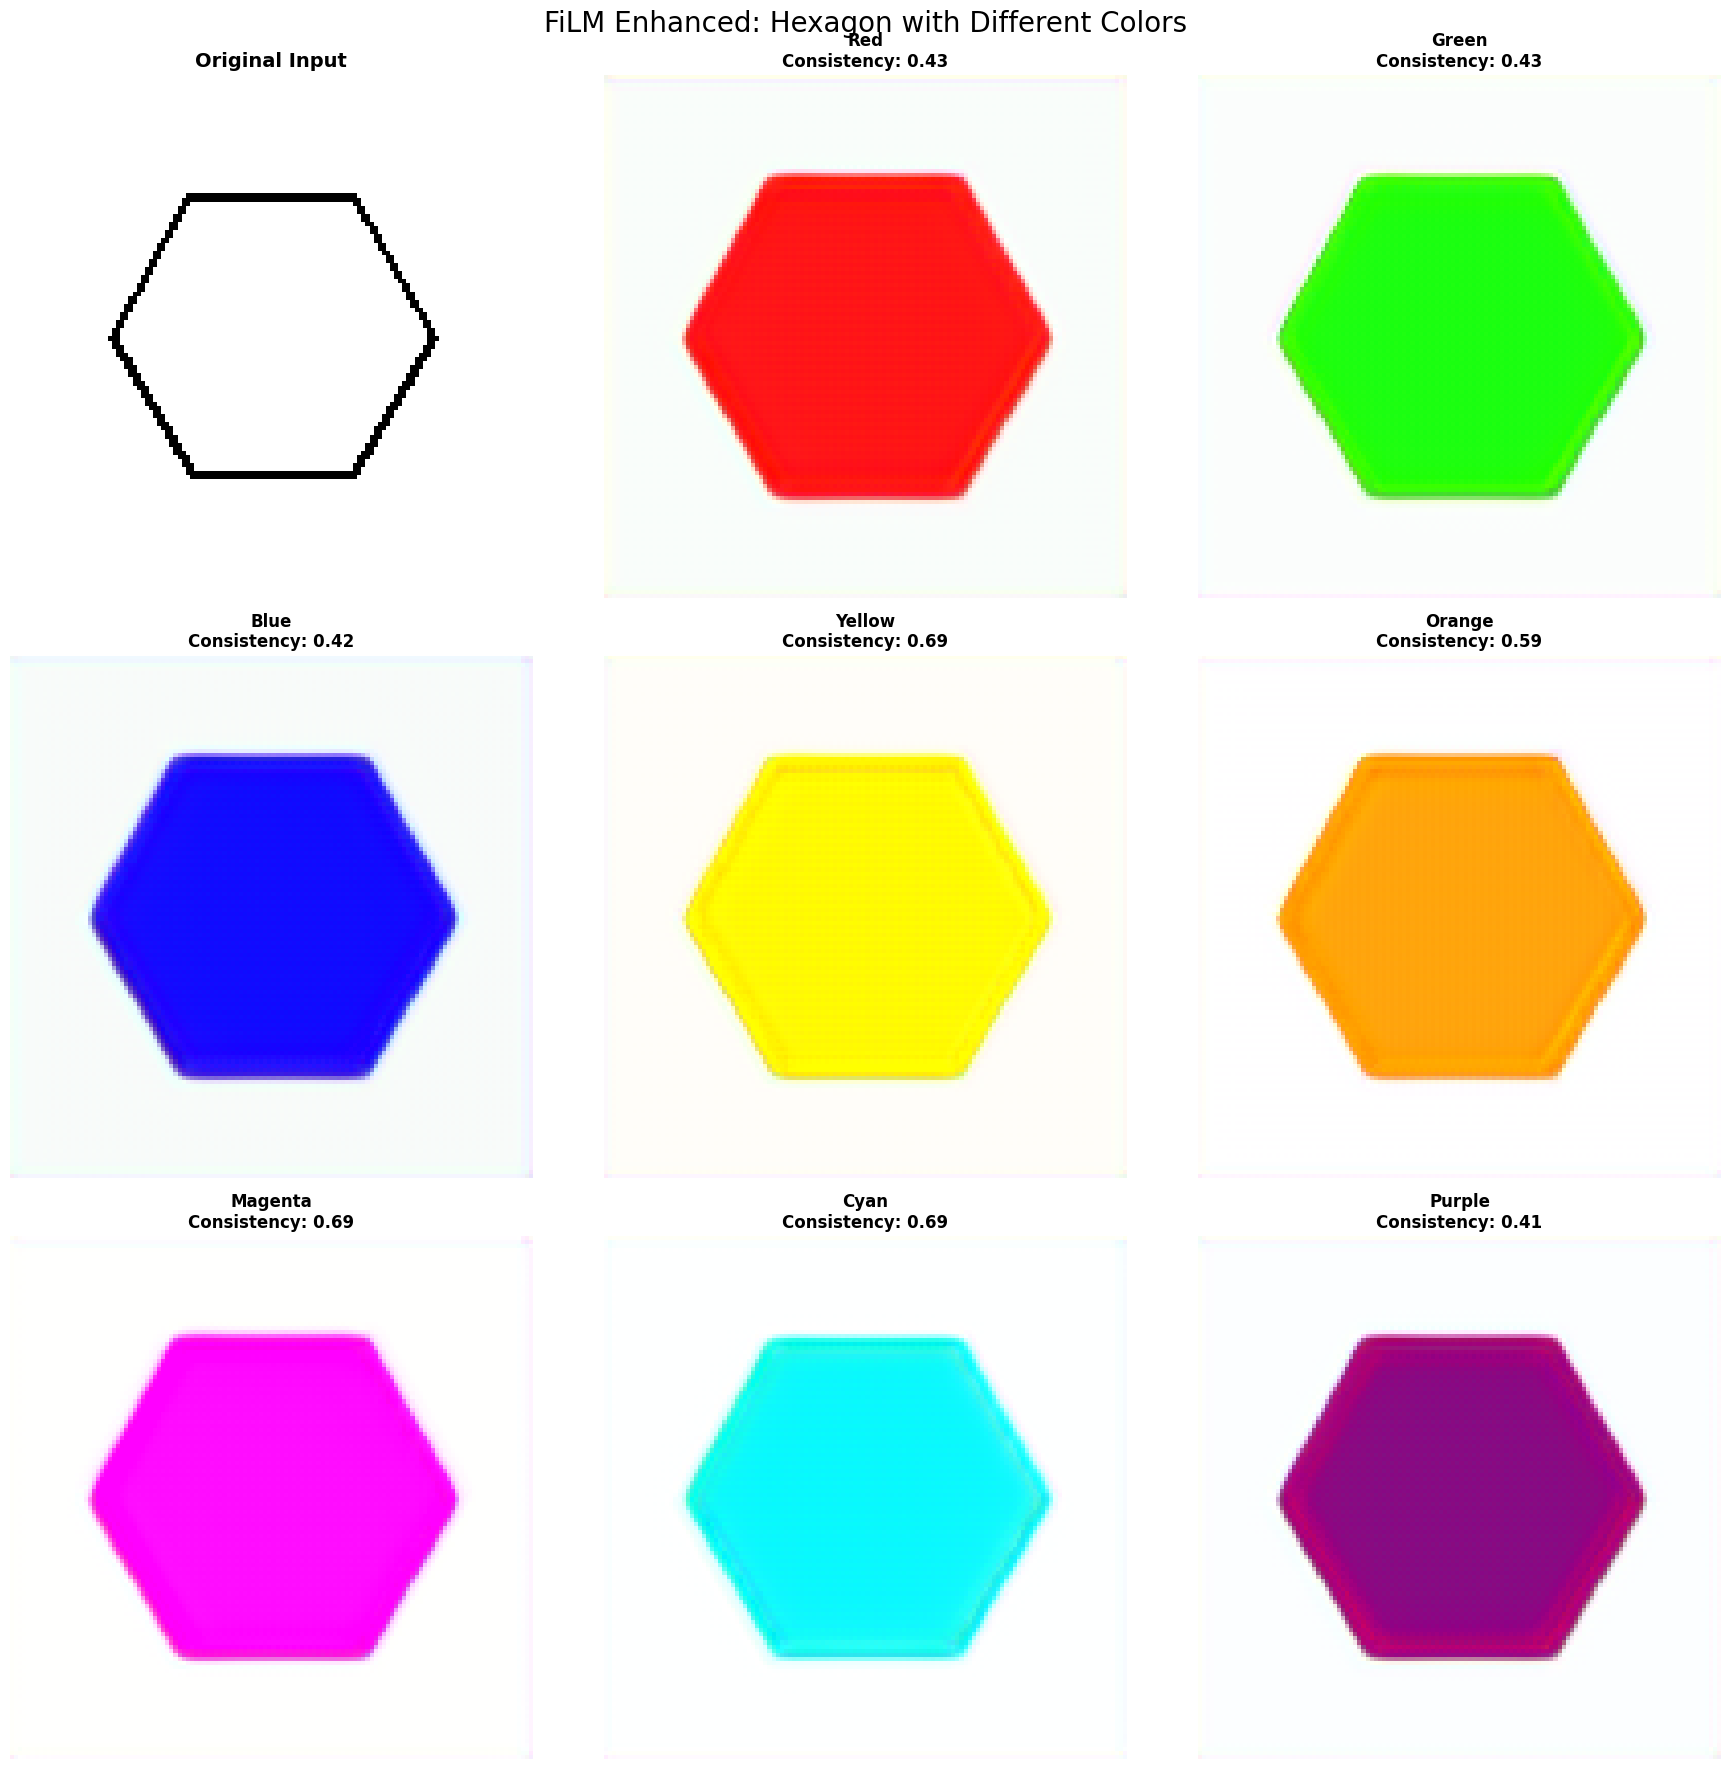


🎨 FiLM Model Testing: Pentagon


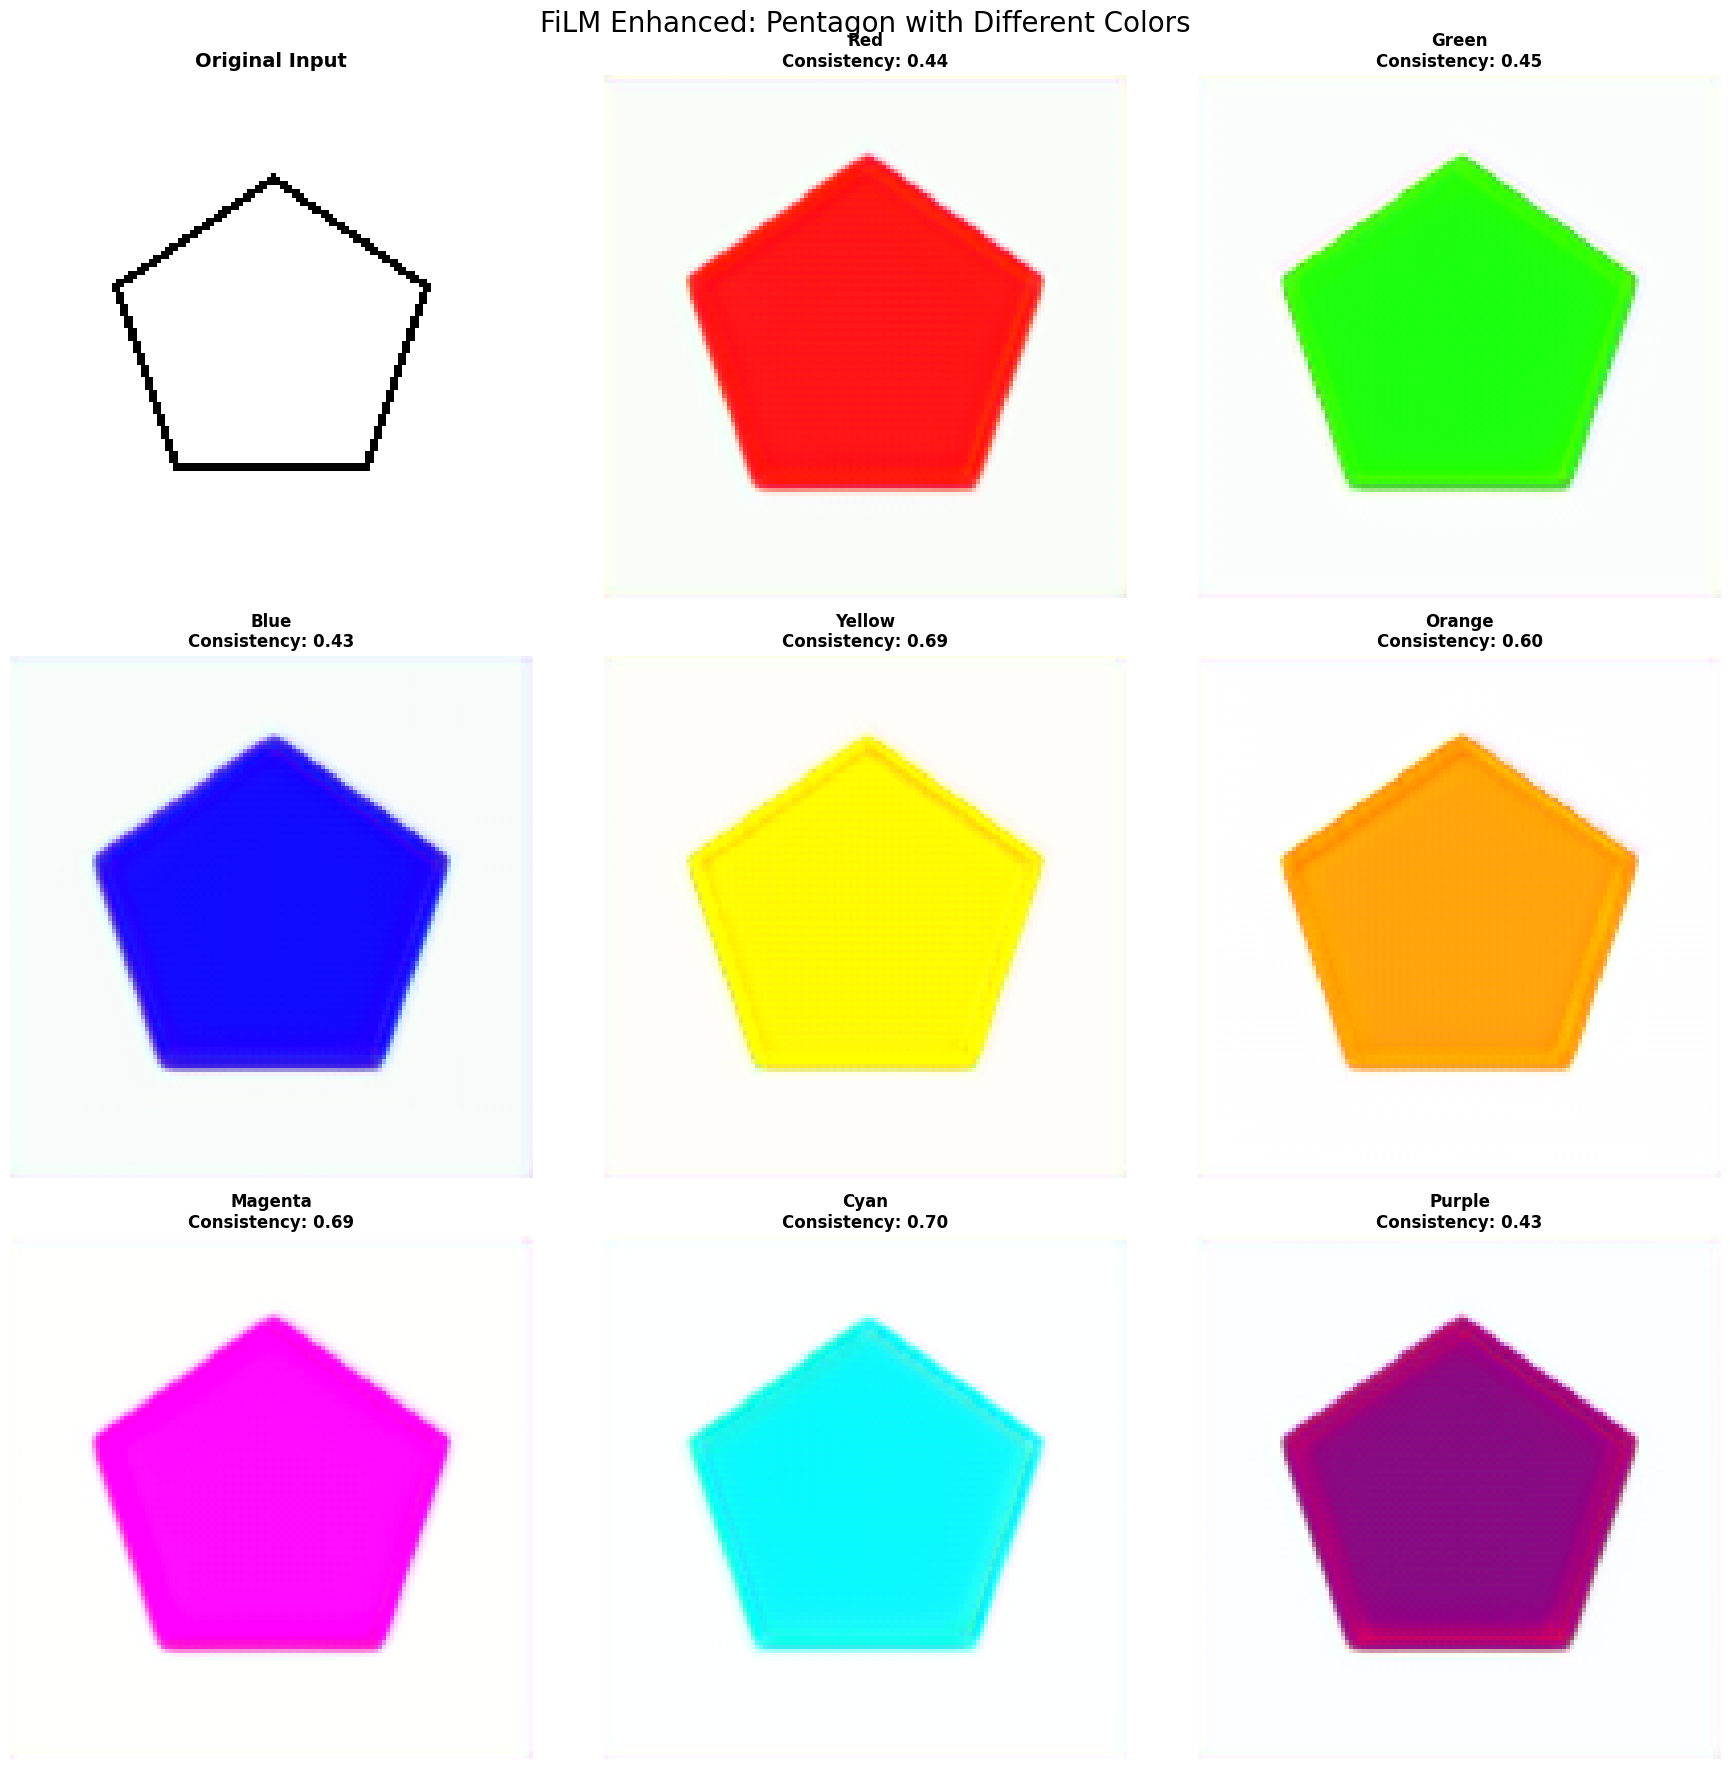


🎨 FiLM Model Testing: Octagon


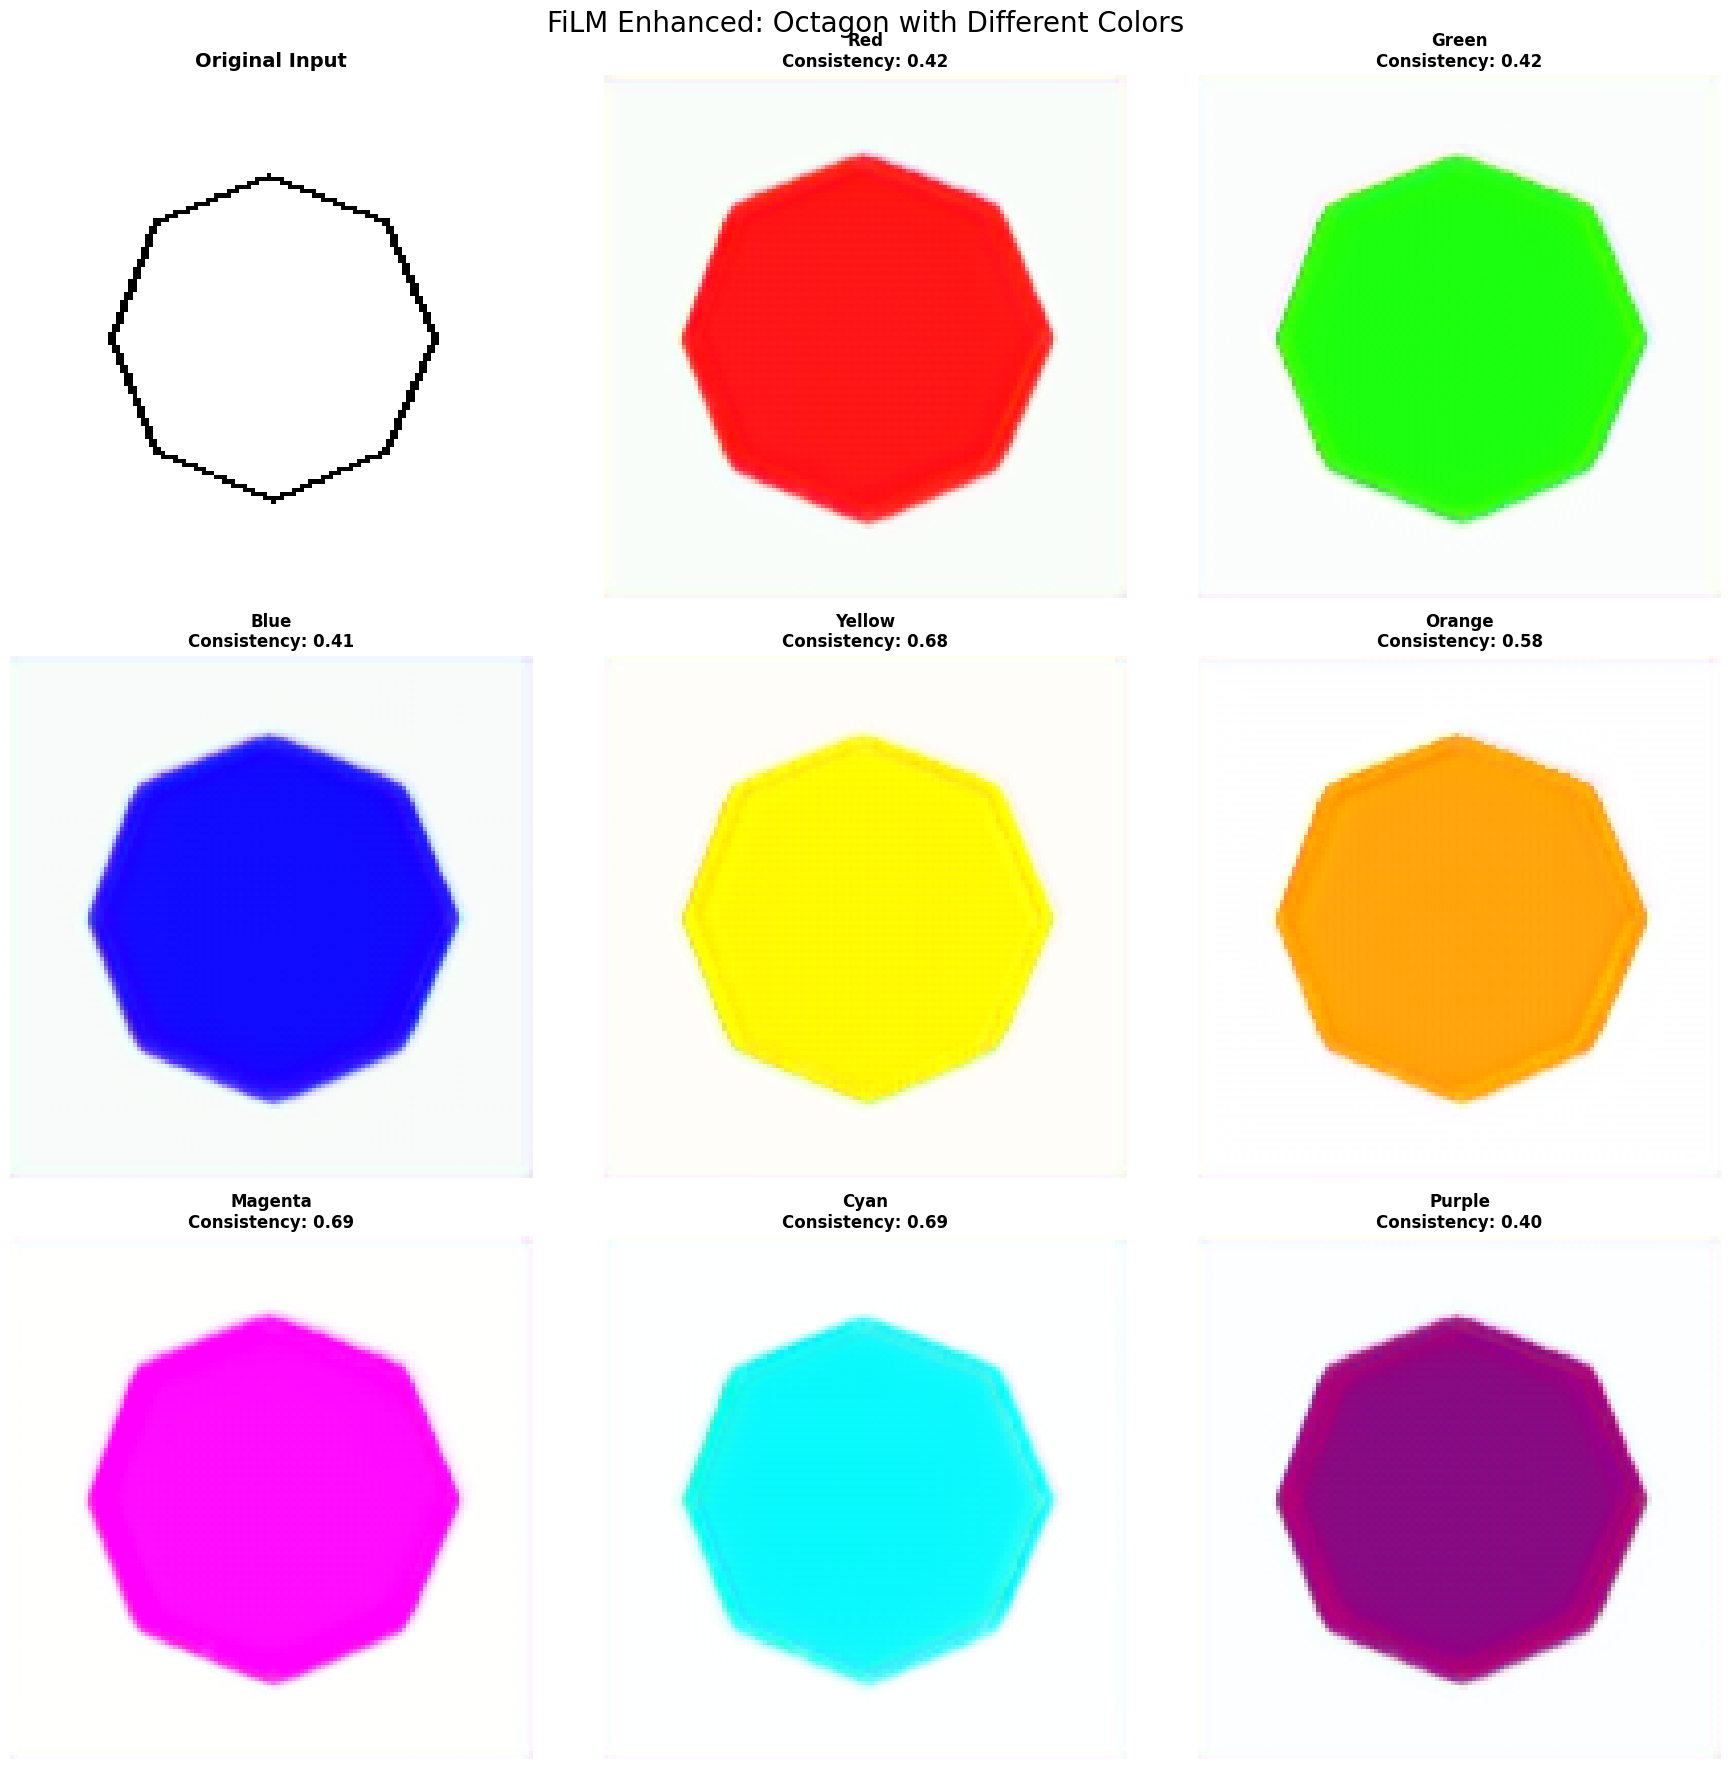


🎨 FiLM Model Testing: Diamond


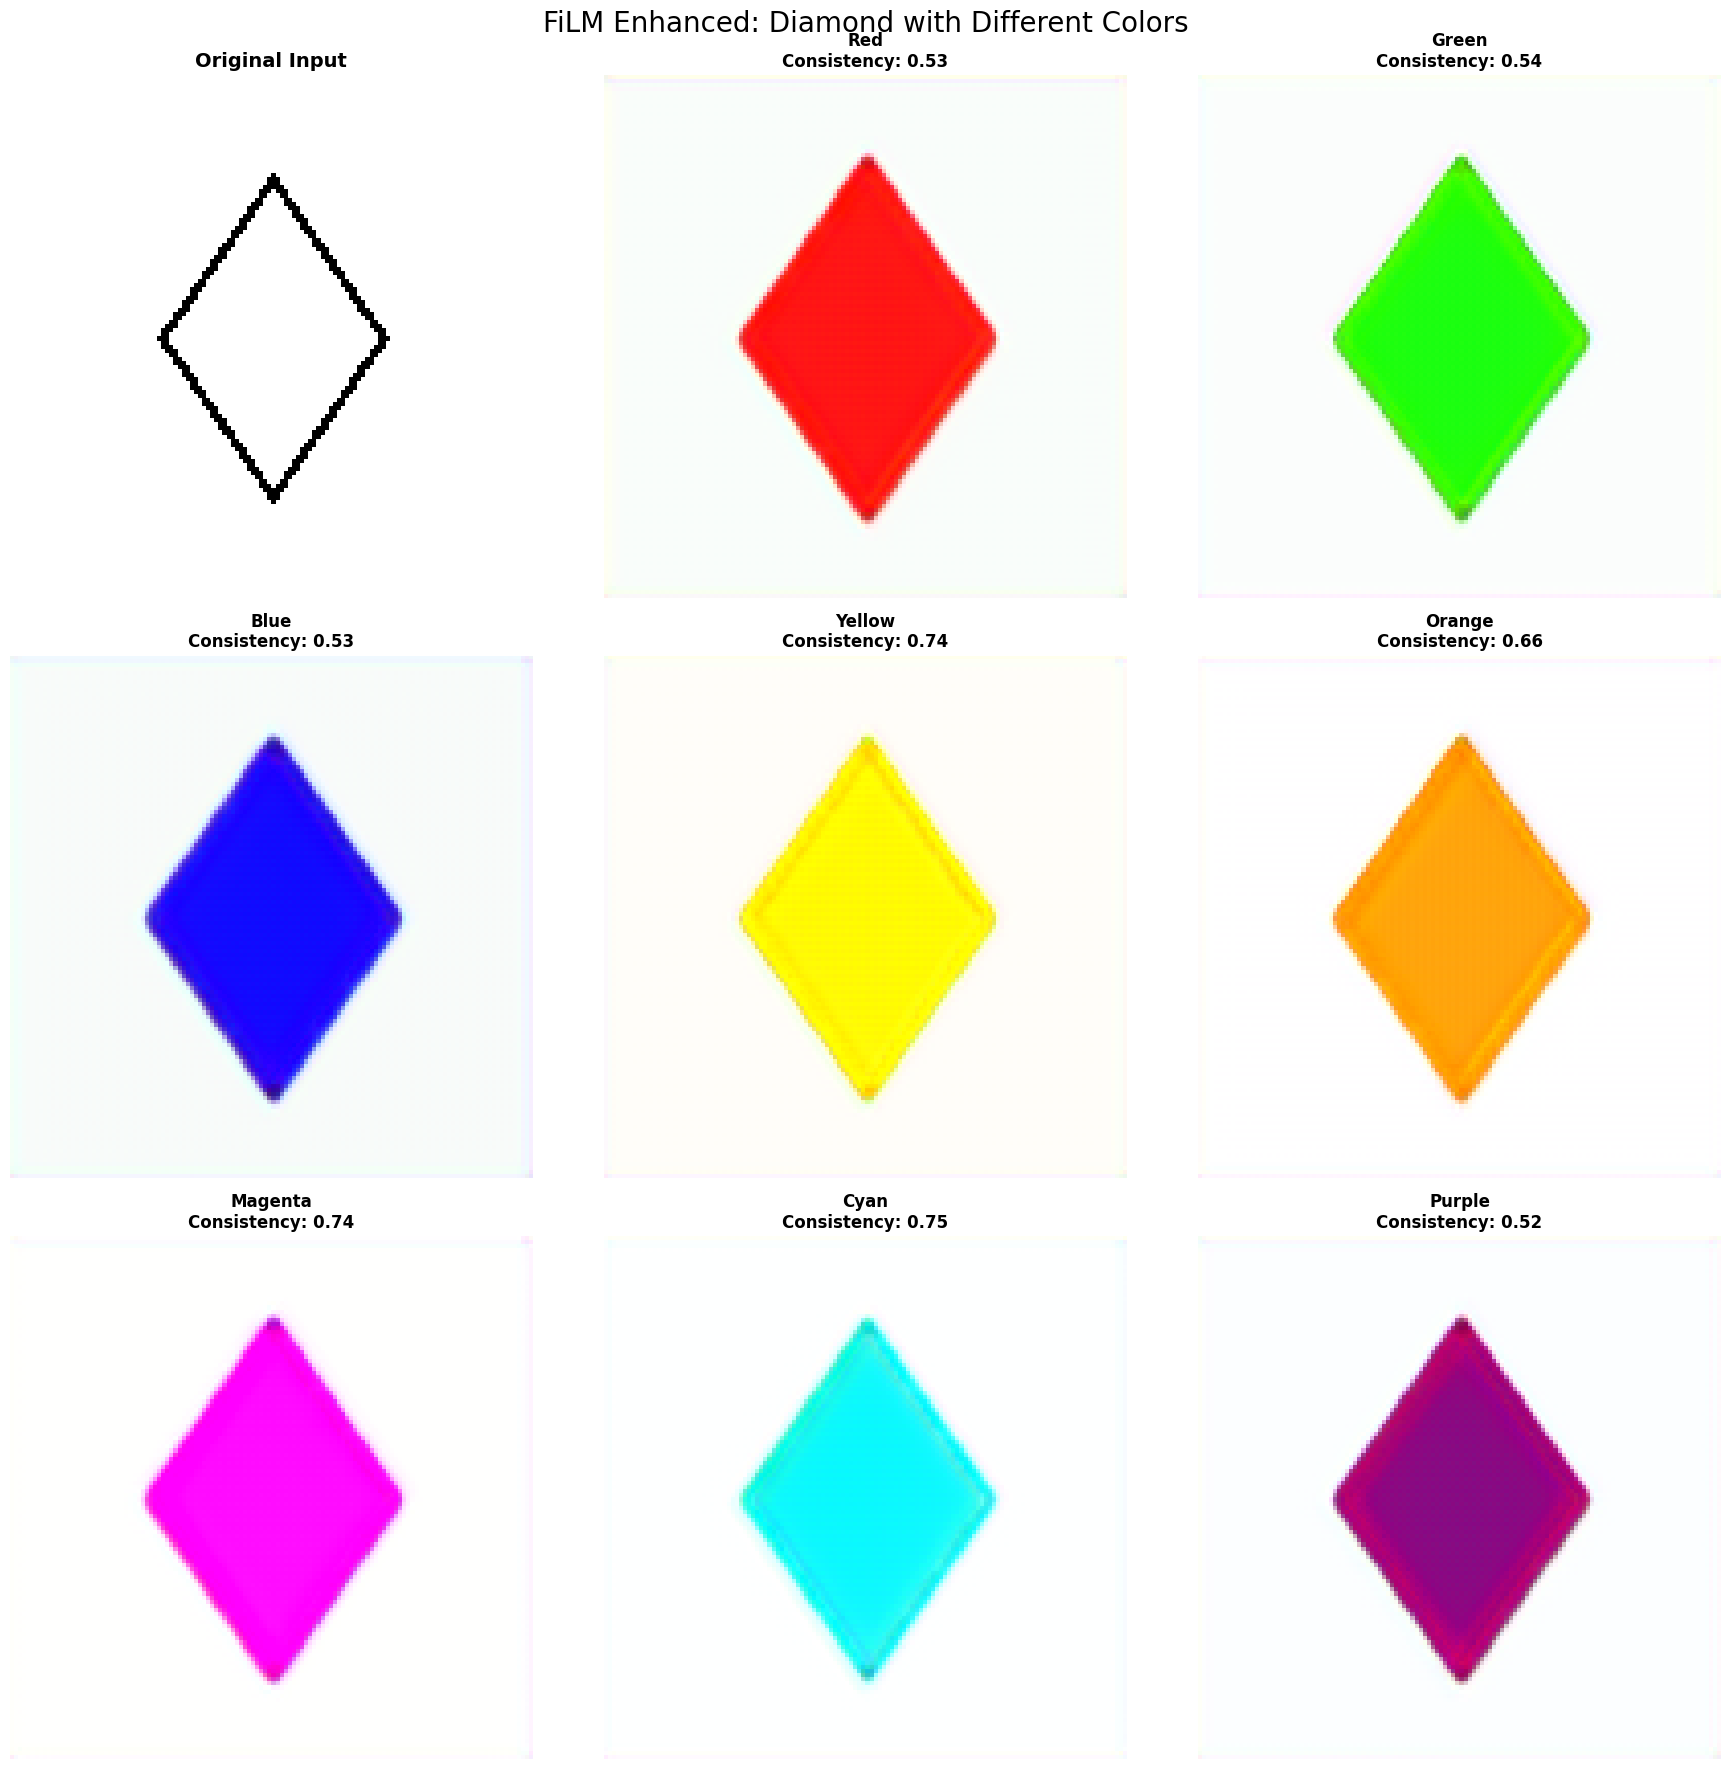


🎨 FiLM Model Testing: Star


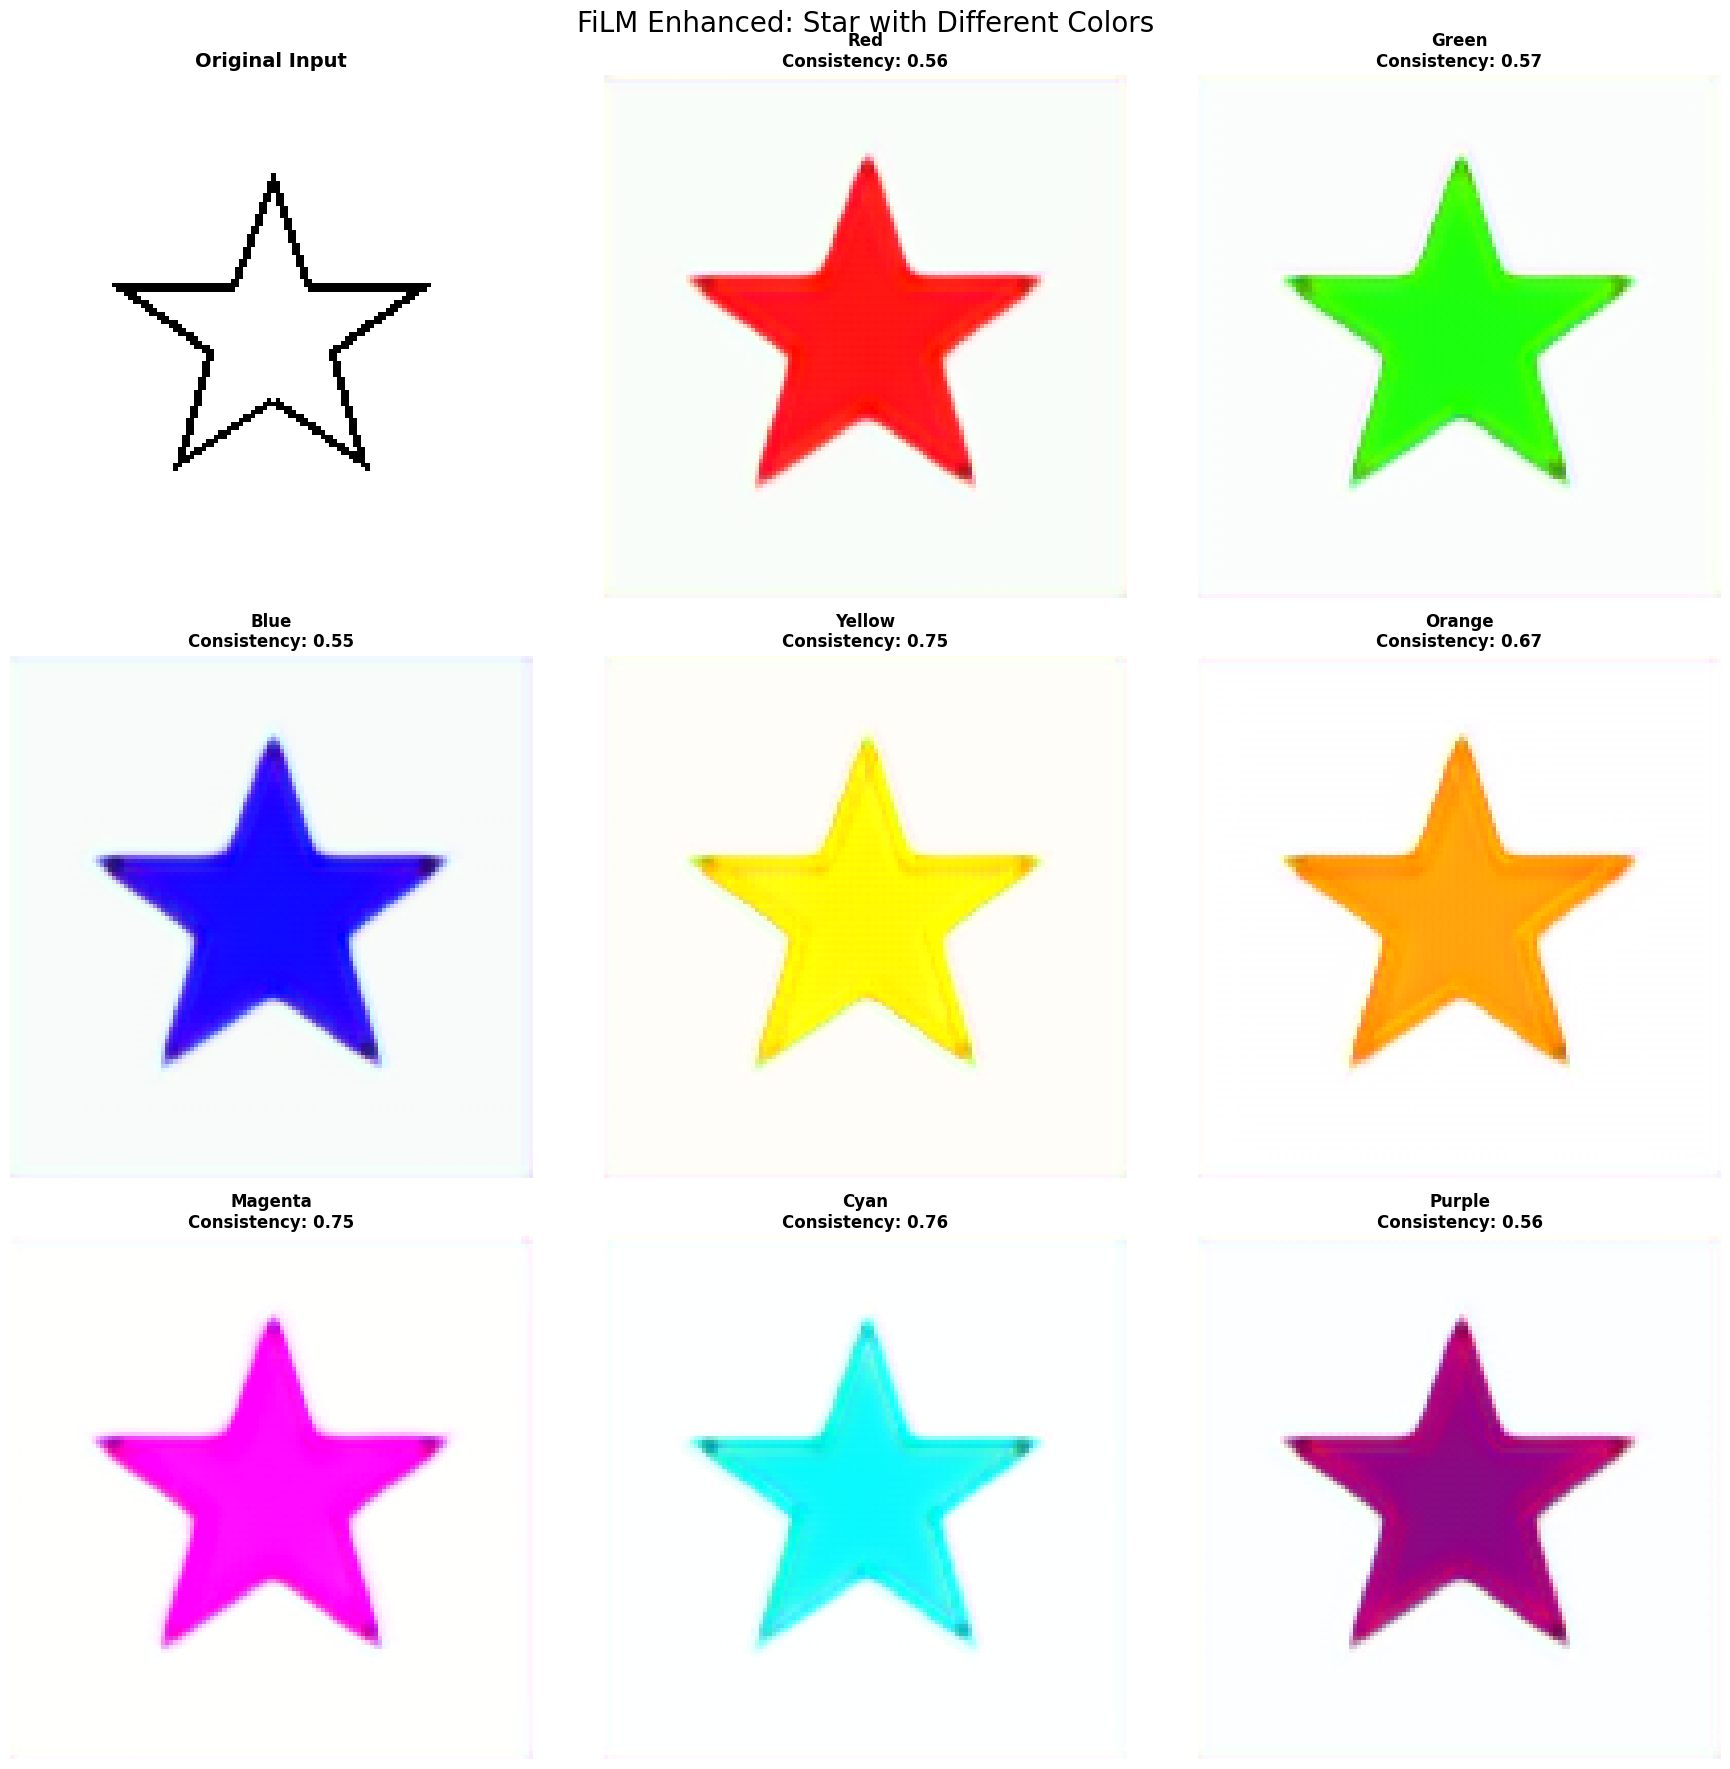


🎨 FiLM Model Testing: Plus


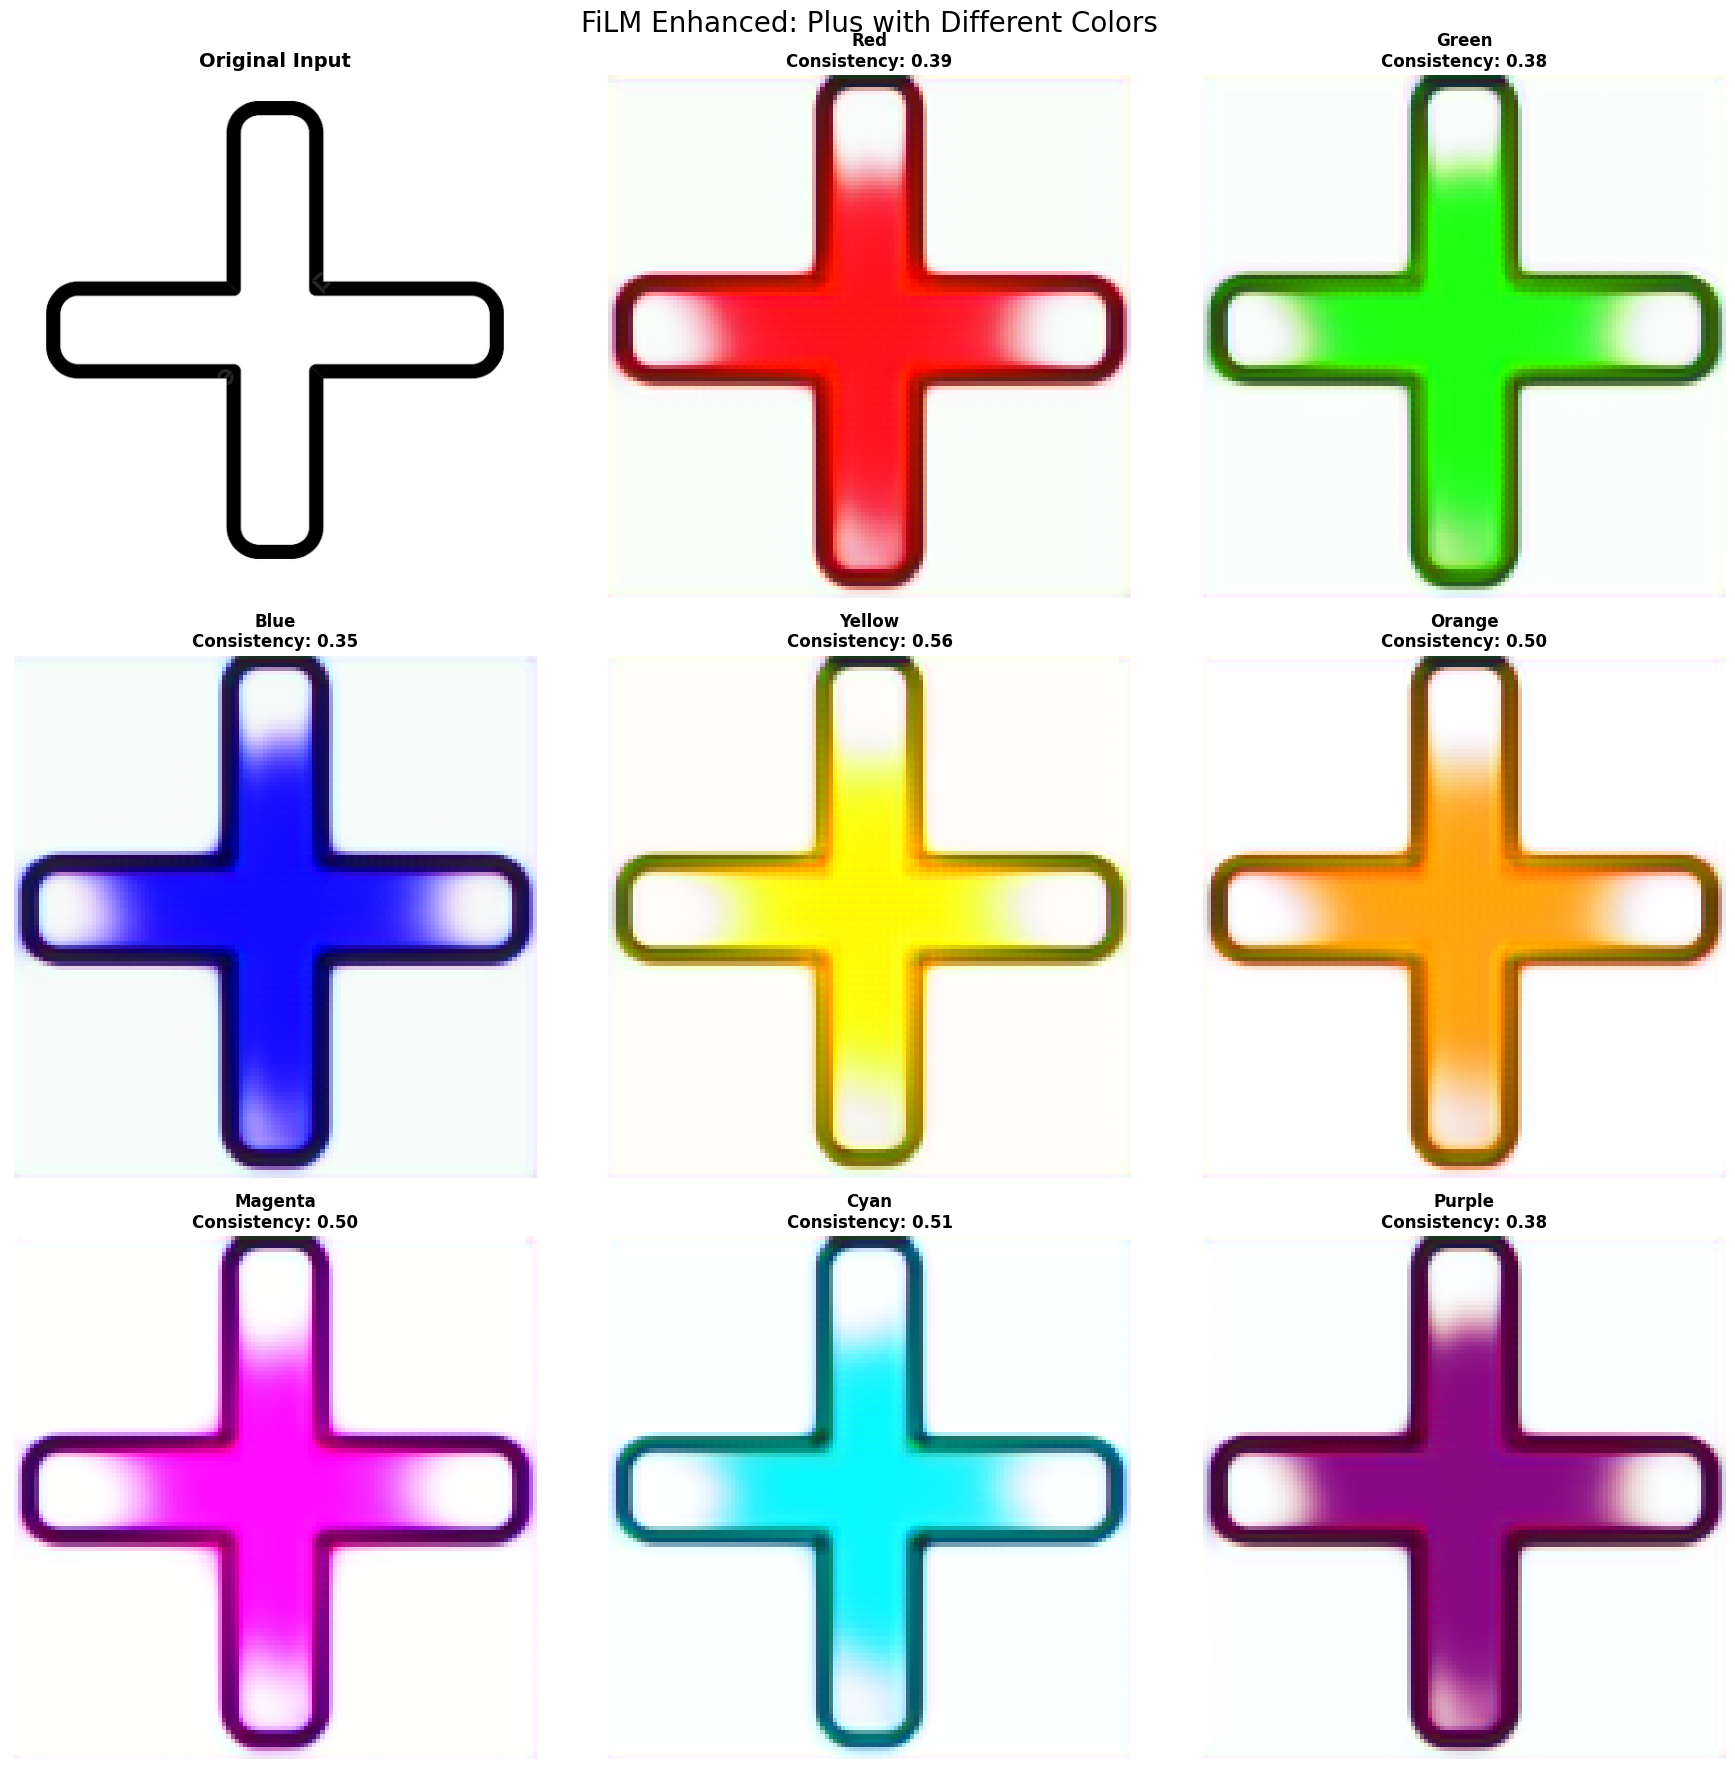


🎨 FiLM Model Testing: Nanogon


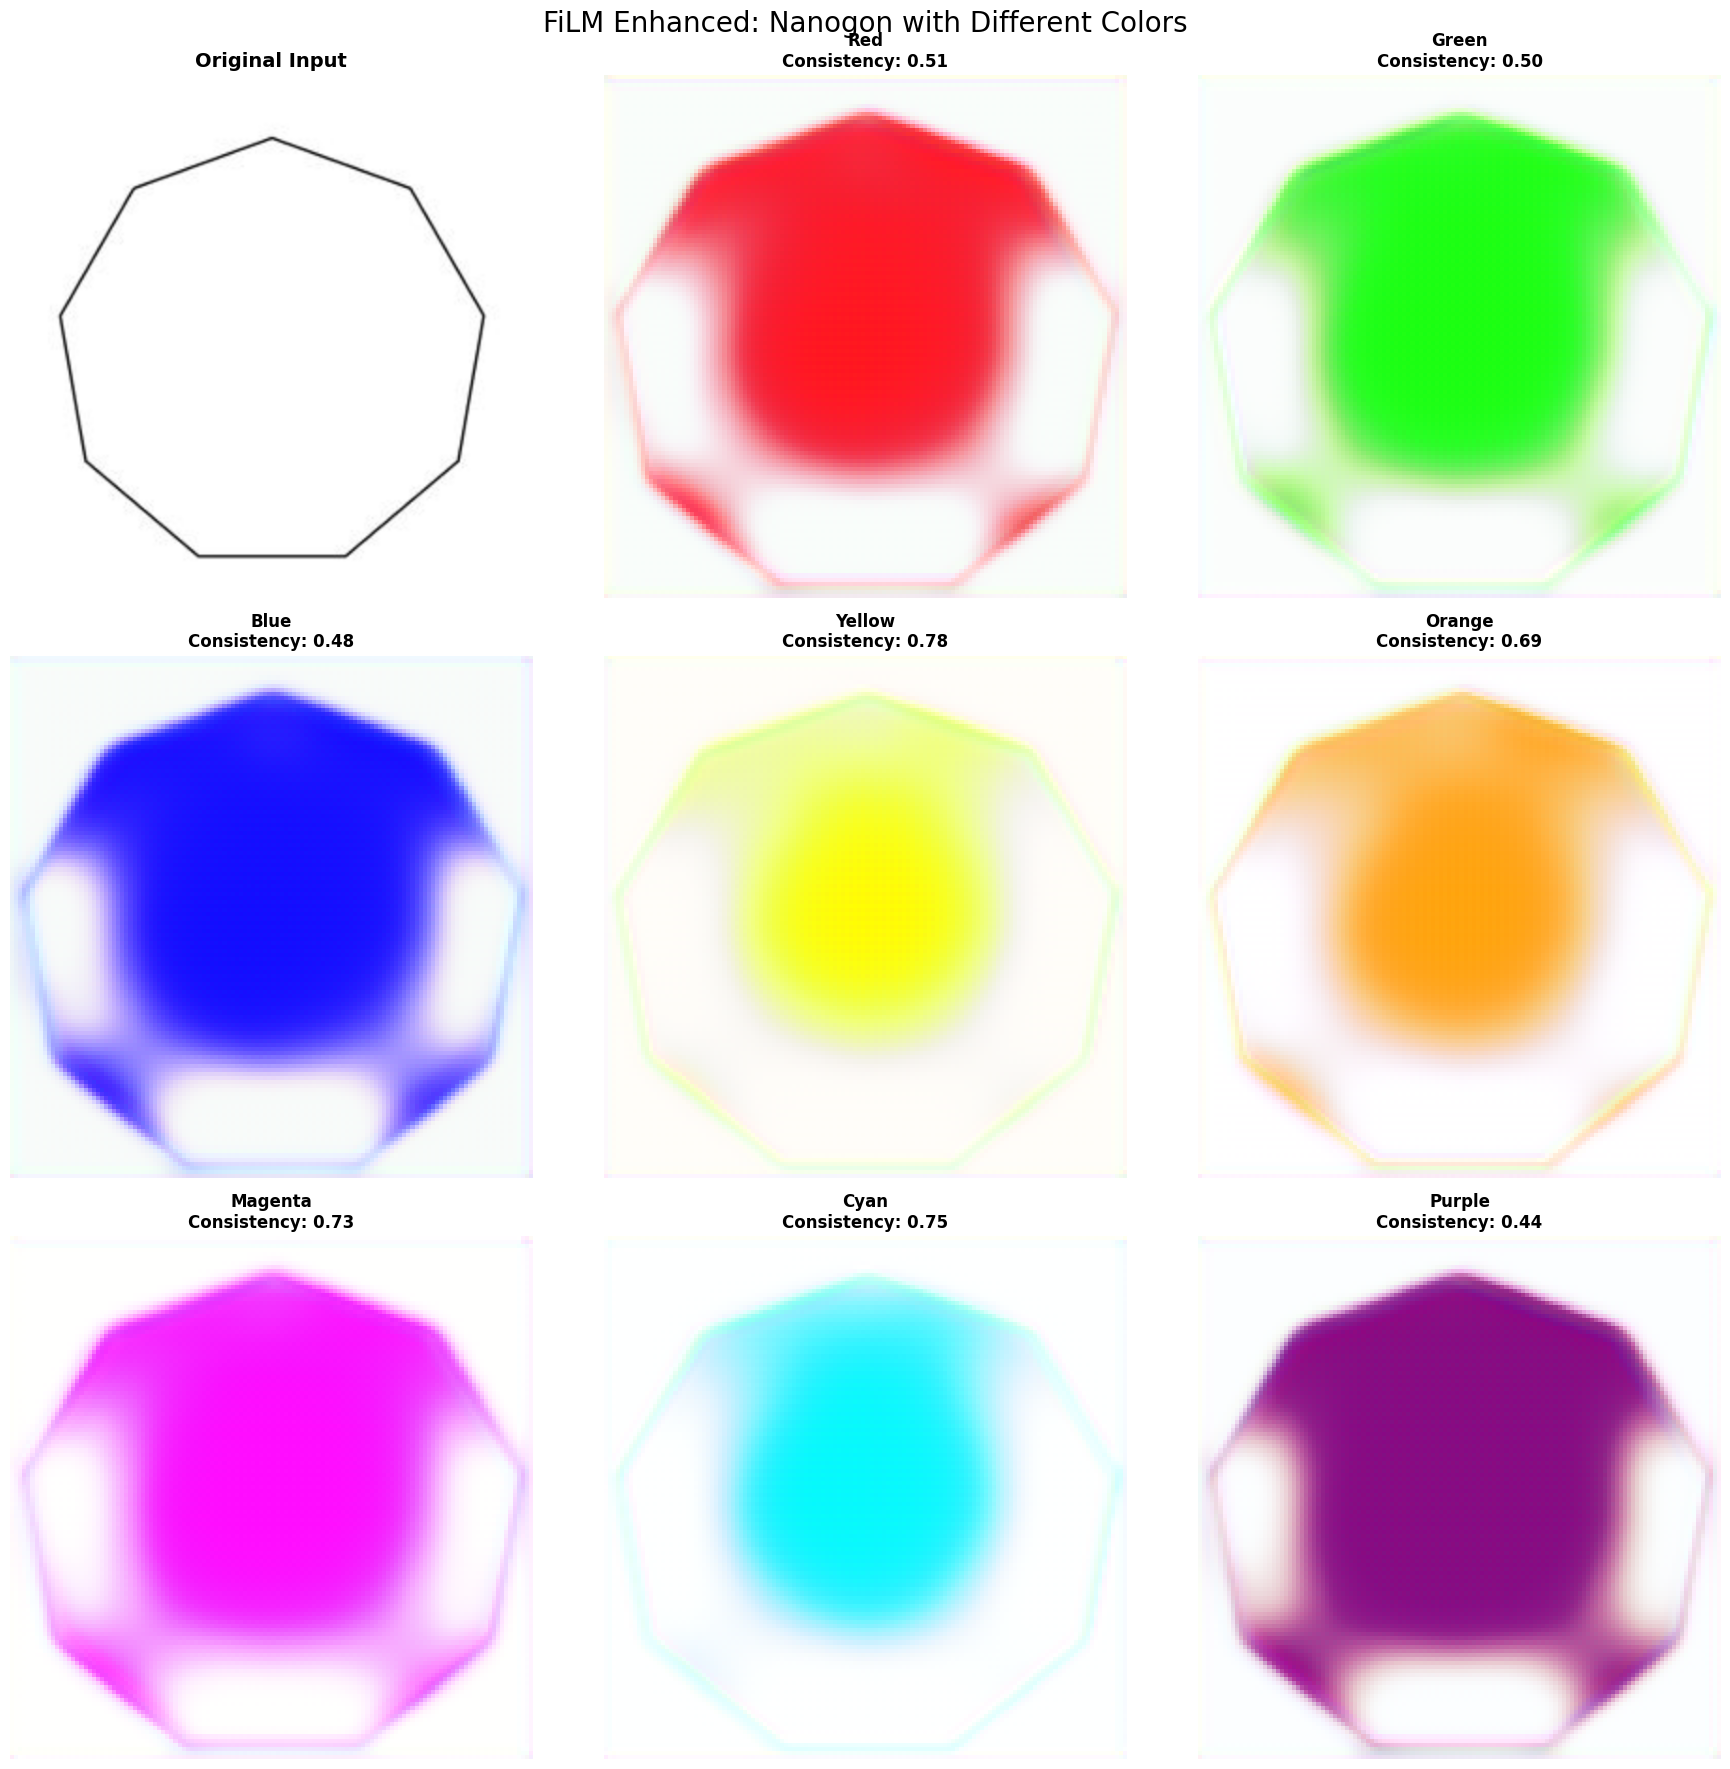

In [7]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import os

# Set paths
input_folder = "/content/drive/MyDrive/ayna_dataset/training/inputs"
model_path = "/content/drive/MyDrive/unet_film_onehot_aug.pth"  # Your FiLM model checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define colors and shapes
COLORS = ["red", "green", "blue", "yellow", "orange", "magenta", "cyan", "purple"]
SHAPES = ["circle", "square", "triangle", "hexagon", "pentagon", "octagon", "diamond", "star","plus","nanogon"]

# Image transform
transform = T.Compose([
    T.Resize((144, 144)),
    T.CenterCrop(128),
    T.ToTensor()
])

# Load FiLM-enhanced UNet model
model = UNetFullFiLM(in_channels=3, cond_dim=8).to(device)

# Handle checkpoint loading (with metadata)
checkpoint = torch.load(model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f" Loaded FiLM model from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f" Best validation loss: {checkpoint.get('best_val_loss', 'unknown'):.4f}")
else:
    model.load_state_dict(checkpoint)
    print(" Loaded FiLM model (legacy format)")

model.eval()

# Run predictions with enhanced visualization
for shape in SHAPES:
    image_path = os.path.join(input_folder, f"{shape}.png")
    if not os.path.exists(image_path):
        print(f" Skipping missing shape: {shape}")
        continue

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    print(f"\n FiLM Model Testing: {shape.title()}")

    # Create enhanced grid visualization
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle(f"FiLM Enhanced: {shape.title()} with Different Colors", fontsize=20)

    # Show original in center
    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Original Input", fontsize=14, weight='bold')
    axes[0, 0].axis('off')

    for i, color in enumerate(COLORS):
        color_vector = color_name_to_onehot(color).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img_tensor, color_vector).squeeze().permute(1, 2, 0).cpu().numpy()
            pred_clipped = pred.clip(0, 1)

        # Calculate color consistency score
        gray_pred = pred_clipped.mean(axis=2)
        filled_region = gray_pred > 0.1
        if filled_region.any():
            color_variance = pred_clipped[filled_region].std(axis=0).mean()
            consistency = max(0, 1 - color_variance * 2)  # Normalize to 0-1
        else:
            consistency = 0

        # Position in grid (skip [0,0] which has original)
        pos = i + 1
        row, col = pos // 3, pos % 3

        axes[row, col].imshow(pred_clipped)
        axes[row, col].set_title(f"{color.title()}\nConsistency: {consistency:.2f}",
                                fontsize=12, weight='bold')
        axes[row, col].axis('off')

        # Add border color based on consistency
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor('green' if consistency > 0.7 else 'orange' if consistency > 0.4 else 'red')
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()
